In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense

In [ ]:
seed_constant = 3
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# configure video directory
base_directory = '/content/drive/MyDrive/videos'

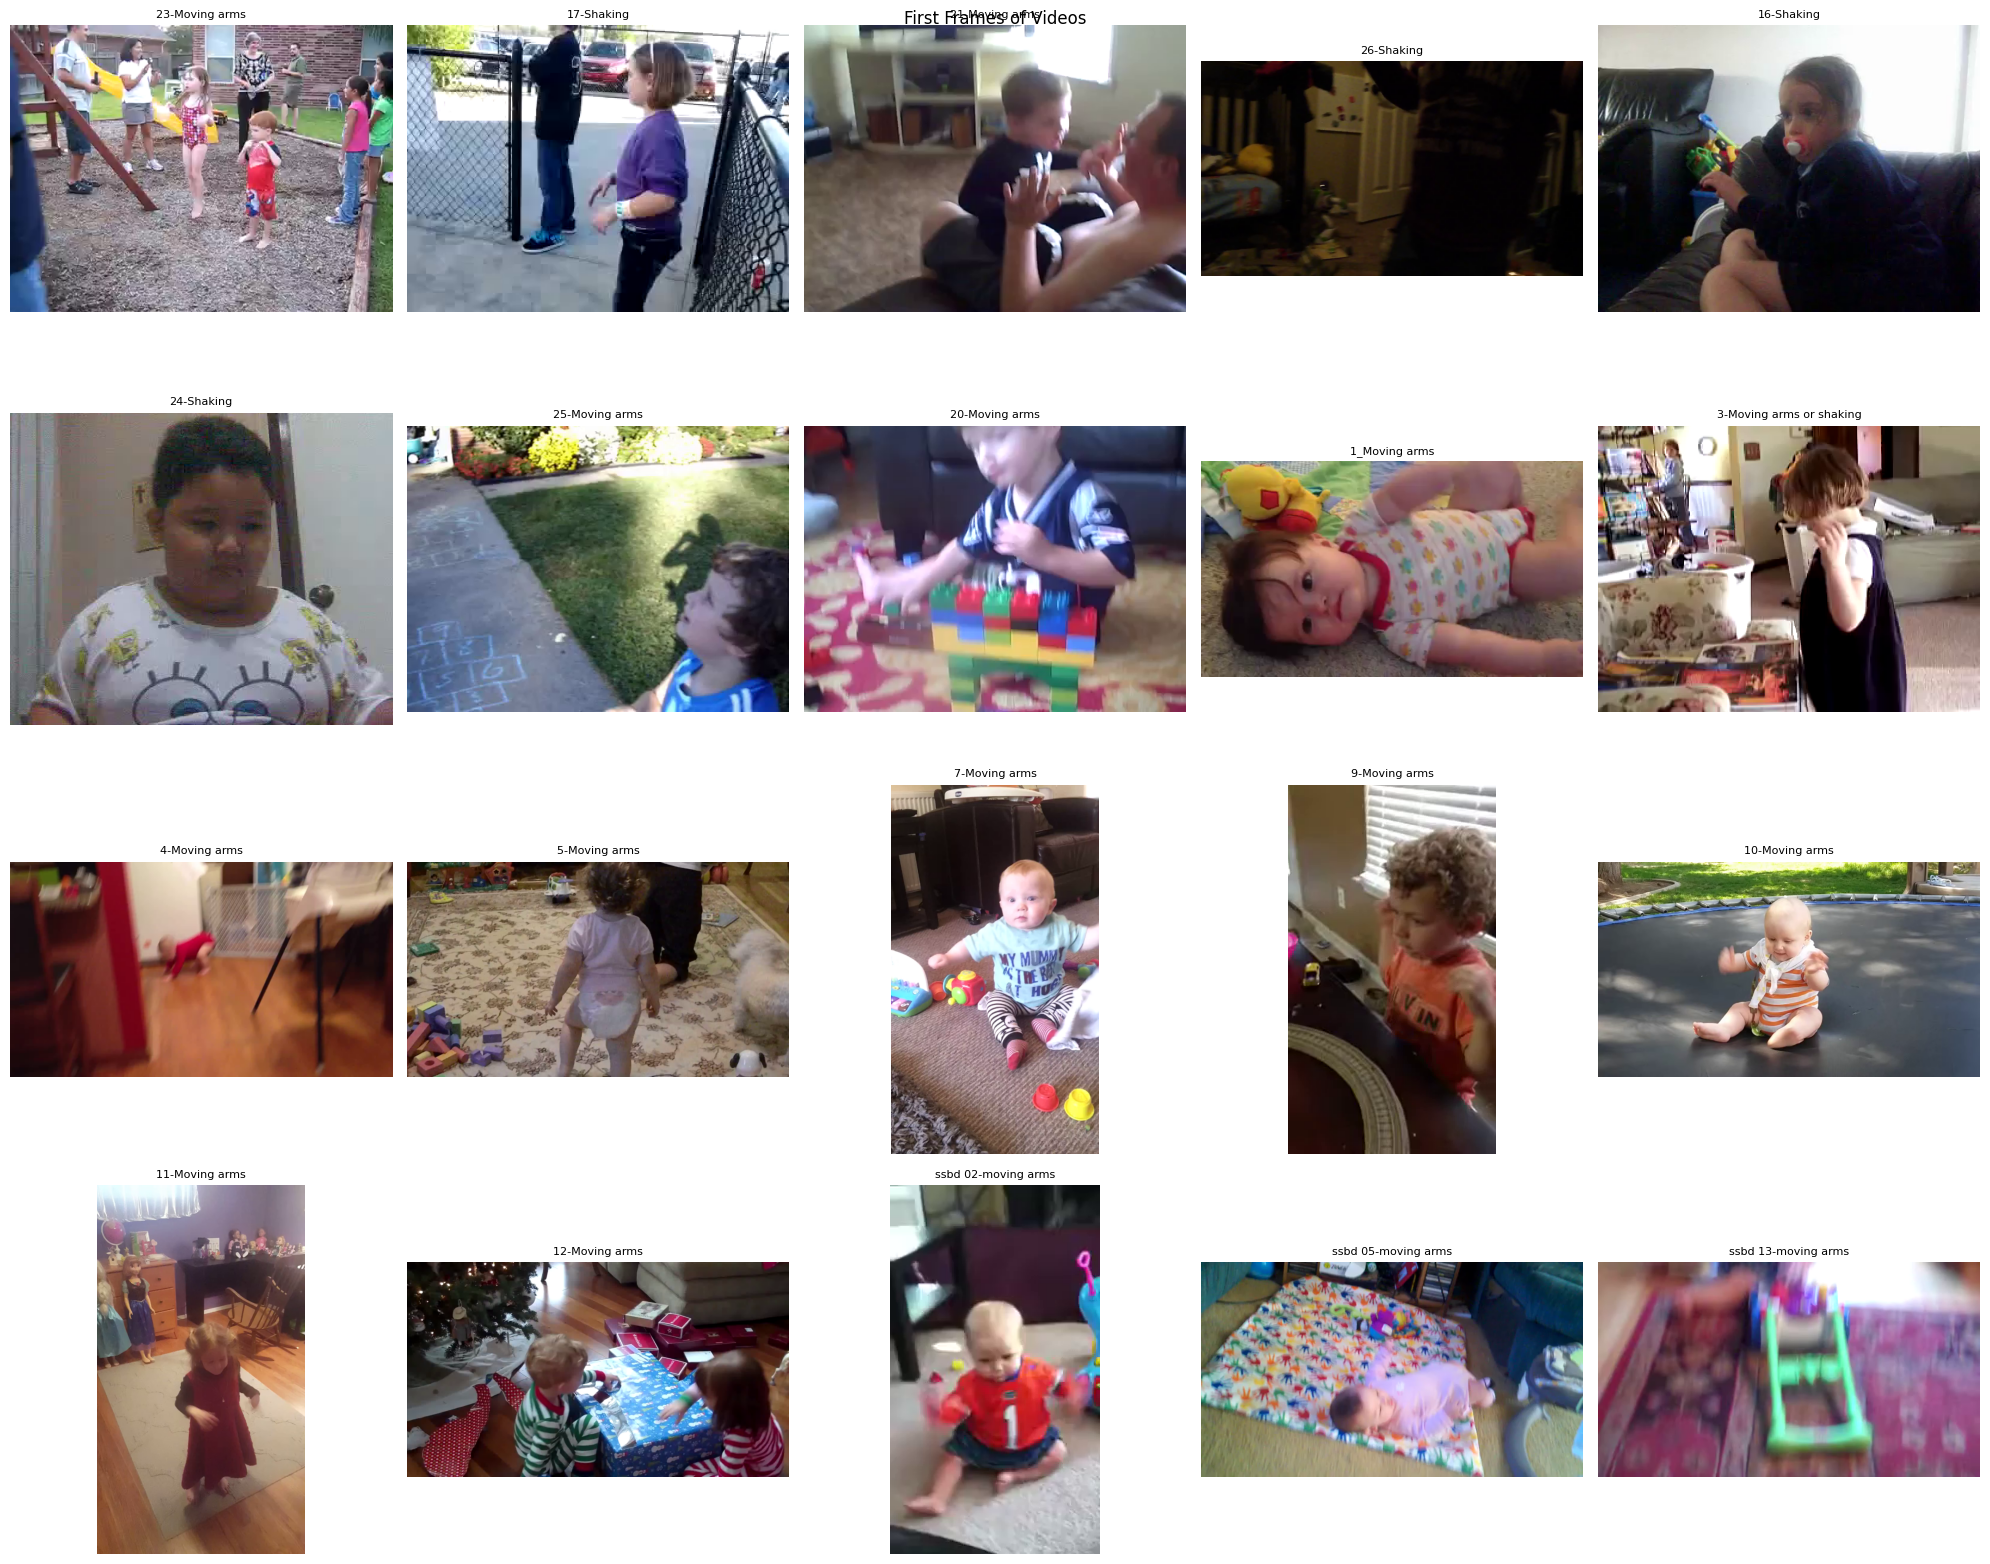

In [ ]:
# Initialize counter and video count
counter = 1
total_videos = 0

# Get the list of all files in the base_directory
all_files = [f for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

# Filter out video files (assuming .mp4, .avi, .mov file types, add other types if needed)
video_files = [f for f in all_files if f.endswith(('.mp4', '.avi', '.mov'))]
total_videos = len(video_files)

# Calculate grid size for subplots
grid_size = int(total_videos**0.5) + 1  # Square root to determine grid dimensions
plt.figure(figsize=(20, 20))

# Process and display each video's first frame
for video in video_files:
    video_path = os.path.join(base_directory, video)
    video_reader = cv2.VideoCapture(video_path)

    if video_reader.isOpened():
        _, bgr_frame = video_reader.read()
        video_reader.release()

        if bgr_frame is not None:
            video_name = video.split('.')[0]
            rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
            plt.subplot(grid_size, grid_size, counter)
            plt.imshow(rgb_frame)
            plt.title(video_name, fontsize=8)
            plt.axis('off')
            counter += 1
        else:
            print(f"Failed to read frame from {video_path}")
    else:
        print(f"Failed to open video {video_path}")

plt.tight_layout()
plt.suptitle('First Frames of Videos')
plt.show()

In [ ]:
video_files = []

# List all files in the base directory and add them to the video_files list if they are files
video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

print(video_files)

['/content/drive/MyDrive/videos/23-Moving arms.mp4', '/content/drive/MyDrive/videos/17-Shaking.mp4', '/content/drive/MyDrive/videos/21-Moving arms.mp4', '/content/drive/MyDrive/videos/26-Shaking.mp4', '/content/drive/MyDrive/videos/16-Shaking.mp4', '/content/drive/MyDrive/videos/24-Shaking.mp4', '/content/drive/MyDrive/videos/25-Moving arms.mp4', '/content/drive/MyDrive/videos/20-Moving arms.mp4', '/content/drive/MyDrive/videos/1_Moving arms.mp4', '/content/drive/MyDrive/videos/3-Moving arms or shaking.mp4', '/content/drive/MyDrive/videos/4-Moving arms.mp4', '/content/drive/MyDrive/videos/5-Moving arms.mp4', '/content/drive/MyDrive/videos/7-Moving arms.mp4', '/content/drive/MyDrive/videos/9-Moving arms.mp4', '/content/drive/MyDrive/videos/10-Moving arms.mp4', '/content/drive/MyDrive/videos/11-Moving arms.mp4', '/content/drive/MyDrive/videos/12-Moving arms.mp4', '/content/drive/MyDrive/videos/ssbd 02-moving arms.mp4', '/content/drive/MyDrive/videos/ssbd 05-moving arms.mp4', '/content/dr

In [ ]:
import cv2
import os

# Assuming video_files is a list of video file paths
video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

def get_video_fps(video_path):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    video.release()
    return fps

# Iterate through the list of video file paths and print their fps
for video_path in video_files:
    fps = get_video_fps(video_path)
    print(f"Video: {video_path}, FPS: {fps}")

Video: /content/drive/MyDrive/videos/23-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/17-Shaking.mp4, FPS: 15.0
Video: /content/drive/MyDrive/videos/21-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/26-Shaking.mp4, FPS: 29.97002997002997
Video: /content/drive/MyDrive/videos/16-Shaking.mp4, FPS: 29.6752
Video: /content/drive/MyDrive/videos/24-Shaking.mp4, FPS: 14.767
Video: /content/drive/MyDrive/videos/25-Moving arms.mp4, FPS: 25.0
Video: /content/drive/MyDrive/videos/20-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/1_Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/3-Moving arms or shaking.mp4, FPS: 23.954
Video: /content/drive/MyDrive/videos/4-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/5-Moving arms.mp4, FPS: 29.97002997002997
Video: /content/drive/MyDrive/videos/7-Moving arms.mp4, FPS: 28.827674567584882
Video: /content/drive/MyDrive/videos/9-Moving arms.mp4, FPS: 24.0
Video: /content/drive/MyDr

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = '/content/drive/MyDrive/videos'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ['nothing', 'hand_shaking', 'moving_arms']

In [ ]:
def timestamp_to_frame(timestamp, standard_fps):
      parts = timestamp.split(':')
      if len(parts) == 2:
          # Format is MM:SS
          m, s = map(int, parts)
          total_seconds = m * 60 + s
      elif len(parts) == 3:
          # Format is HH:MM:SS
          h, m, s = map(int, parts)
          total_seconds = h * 3600 + m * 60 + s
      else:
          raise ValueError(f"Invalid timestamp format: {timestamp}")

      return int(total_seconds * standard_fps)

In [ ]:
def classify_frames(video_path, action_intervals, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # print(f"Processing video: {video_path}")
    # print(f"Total frames: {total_frames}")

    action_frames = {action: [] for action in action_intervals}
    action_frames['nothing'] = []
    frame_counts = {action: 0 for action in action_intervals}
    frame_counts['nothing'] = 0

    for frame_num in range(total_frames):
        success, frame = video.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (image_width, image_height))
        normalized_frame = resized_frame / 255.0

        label = 'nothing'
        for action, intervals in action_intervals.items():
            for start_time, end_time in intervals:
                start_frame = timestamp_to_frame(start_time, standard_fps)
                end_frame = timestamp_to_frame(end_time, standard_fps)
                if start_frame <= frame_num <= end_frame:
                    label = action
                    break
            if label != 'nothing':
                break

        action_frames[label].append(normalized_frame)
        frame_counts[label] += 1

    # print(f"Frame counts for {video_path}: {frame_counts}")
    video.release()
    return action_frames

In [ ]:
video_timestamps = {
    '/content/drive/MyDrive/videos/10-Moving arms.mp4': {
        'moving_arms': [('00:00', '00:03'),
                        ('00:03', '00:05'),
                        ('00:16', '00:19'),
                        ('00:21', '00:23'),
                        ('00:25', '00:27'),
                        ('00:30', '00:32'),
                        ('00:39', '00:43'),
                        ('01:01', '01:02'),
                        ('01:09', '01:13'),
                        ('01:14', '01:16'),
                        ('01:30', '01:32'),
                        ('01:39', '01:41')]
    },
    '/content/drive/MyDrive/videos/11-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02')]
    },
    '/content/drive/MyDrive/videos/12-Moving arms.mp4':{
        'hand_shaking':[('00:07', '00:09'), ('00:14', '00:19'), ('00:34', '00:36')]
    },
    '/content/drive/MyDrive/videos/16-Shaking.mp4':{
        'hand_shaking':[('00:03', '00:11'), ('00:12', '00:15'), ('00:15', '00:30'), ('00:31', '00:33'), ('00:42', '00:46'),
                        ('00:48', '00:51'), ('01:03', '01:11'), ('01:14', '01:17'), ('01:18', '01:25'), ('01:28', '01:31'),
                        ('01:33', '01:39'), ('01:44', '01:57'), ('01:59', '02:09'), ('02:11', '02:36'), ('02:41', '02:42'), ('02:43', '02:44')]
    },
    '/content/drive/MyDrive/videos/17-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:07'), ('00:40', '00:44')]
    },
    '/content/drive/MyDrive/videos/1_Moving arms.mp4':{
        'moving_arms':[('00:38', '00:41'), ('01:05', '01:08'), ('01:38', '01:40'), ('01:50', '01:55'), ('02:16', '02:19')]
    },
    '/content/drive/MyDrive/videos/20-Moving arms.mp4':{
        'moving_arms':[('00:04', '00:08'), ('00:28', '00:30'), ('00:41', '00:43'), ('00:46', '00:50')]
    },
    '/content/drive/MyDrive/videos/21-Moving arms.mp4':{
        'moving_arms':[('02:58', '03:12'), ('03:26', '03:39')]
    },
    '/content/drive/MyDrive/videos/23-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02'), ('00:07', '00:09'), ('00:14', '00:16')]
    },
    '/content/drive/MyDrive/videos/24-Shaking.mp4':{
        'hand_shaking':[('00:02', '00:06'), ('00:17', '00:18'), ('00:23', '00:26'), ('00:32', '00:36'), ('00:42', '00:50'),
                        ('00:52', '00:56'), ('01:00', '01:01'), ('01:03', '01:07'), ('01:11', '01:14'), ('01:15', '01:19'),
                        ('01:20', '01:25'), ('01:26', '01:30'), ('01:34', '01:42'), ('01:44', '01:45'), ('01:51', '02:00')]
    },
    '/content/drive/MyDrive/videos/25-Moving arms.mp4':{
        'hand_shaking':[('00:08', '00:10'), ('00:11', '00:14')],
        'moving_arms':[('00:21', '00:22'), ('00:33', '00:34')]
    },
    '/content/drive/MyDrive/videos/26-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:08'), ('00:11', '00:12')]
    },
    '/content/drive/MyDrive/videos/3-Moving arms or shaking.mp4':{
        'hand_shaking':[('00:00', '00:04'), ('00:13', '00:15'), ('00:18', '00:19'), ('00:22', '00:27'), ('00:33', '00:36'),
                        ('00:42', '00:46'), ('00:50', '00:54'), ('00:56', '00:57'), ('01:06', '01:07'), ('01:09', '01:11'),
                        ('01:12', '01:15'), ('01:16', '01:18'), ('01:19', '01:23'), ('01:31', '01:32'), ]
    },
    '/content/drive/MyDrive/videos/4-Moving arms.mp4':{
        'moving_arms':[('00:03', '00:09')]
    },
    '/content/drive/MyDrive/videos/5-Moving arms.mp4':{
        'hand_shaking':[('00:04', '00:08'), ('00:09', '00:12')]
    },
    '/content/drive/MyDrive/videos/7-Moving arms.mp4':{
        'moving_arms':[('00:06', '00:08'), ('00:09', '00:11'), ('00:15', '00:18'), ('00:19', '00:21')]
    },
    '/content/drive/MyDrive/videos/9-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:03'), ('00:05', '00:07'), ('00:18', '00:27')]
    },
    '/content/drive/MyDrive/videos/ssbd 02-moving arms.mp4':{
        'moving_arms':[('00:00', '00:03'), ('00:12', '00:16'), ('00:20', '00:23'), ('00:29', '00:32')]
    },
    '/content/drive/MyDrive/videos/ssbd 05-moving arms.mp4':{
        'moving_arms':[('00:03', '00:07'), ('00:08', '00:10'), ('00:11', '00:12'), ('00:13', '00:15'), ]
    },
    '/content/drive/MyDrive/videos/ssbd 13-moving arms.mp4':{
        'moving_arms':[('00:19', '00:22'), ('00:40', '00:46'), ('00:48', '00:53'), ]
    }
}

In [ ]:
def create_dataset(video_timestamps, sequence_length=SEQUENCE_LENGTH, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    features = []
    labels = []
    video_files_paths = []

    # Explicitly define CLASSES_LIST
    CLASSES_LIST = ['hand_shaking', 'nothing', 'moving_arms']
    label_mapping = {label: idx for idx, label in enumerate(CLASSES_LIST)}

    sequence_counts = {label: 0 for label in CLASSES_LIST}  # Initialize sequence count for each label

    for video_path, actions in video_timestamps.items():
        classified_frames = classify_frames(video_path, actions, standard_fps, image_height, image_width)

        for label, frames in classified_frames.items():
            for i in range(0, len(frames), sequence_length):
                sequence = frames[i:i + sequence_length]

                # Ensure the sequence is complete
                if len(sequence) == sequence_length:
                    features.append(sequence)
                    labels.append(label_mapping[label])
                    video_files_paths.append(video_path)
                    sequence_counts[label] += 1  # Count each complete sequence

    features = np.asarray(features)
    labels = np.array(labels)

    print("CLASSES_LIST:", CLASSES_LIST)
    print("Label Mapping:", label_mapping)

    # Print sequence count for each class
    for label, count in sequence_counts.items():
        print(f"Total sequences in class '{label}': {count}")

    return features, labels, video_files_paths, CLASSES_LIST

In [ ]:
from sklearn.model_selection import train_test_split

video_paths = list(video_timestamps.keys())

# Split the video paths into training and test sets
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Create two separate dictionaries for training and test sets
train_timestamps = {video: video_timestamps[video] for video in train_videos}
test_timestamps = {video: video_timestamps[video] for video in test_videos}

# Generate datasets for training and testing
train_features, train_labels, train_video_files_paths, CLASSES_LIST = create_dataset(train_timestamps)
test_features, test_labels, test_video_files_paths, _ = create_dataset(test_timestamps)

print(CLASSES_LIST)

CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
['hand_shaking', 'nothing', 'moving_arms']


In [ ]:
frames_per_class = {label: [] for label in CLASSES_LIST}

for video_path, actions in video_timestamps.items():
    classified_frames = classify_frames(video_path, actions)
    for label, frames in classified_frames.items():
        frames_per_class[label].extend(frames)

for label in CLASSES_LIST:
    print(f"Total frames in class '{label}': {len(frames_per_class[label])}")

Total frames in class 'hand_shaking': 4034
Total frames in class 'nothing': 34339
Total frames in class 'moving_arms': 2095


In [ ]:
from collections import Counter

overlap = set(train_videos).intersection(set(test_videos))
print(f"Number of overlapping videos: {len(overlap)}")
assert len(overlap) == 0, "Overlap detected between training and test sets"

total_videos = len(video_paths)
num_train = len(train_videos)
num_test = len(test_videos)

print(f"Total number of videos: {total_videos}")
print(f"Number in training set: {num_train} ({num_train/total_videos*100:.2f}%)")
print(f"Number in test set: {num_test} ({num_test/total_videos*100:.2f}%)")

def get_class_distribution(video_set, video_timestamps):
    class_distribution = Counter()
    for video in video_set:
        for action in video_timestamps[video].keys():
            class_distribution[action] += 1
    return class_distribution

train_distribution = get_class_distribution(train_videos, video_timestamps)
test_distribution = get_class_distribution(test_videos, video_timestamps)

print("Training set class distribution:", train_distribution)
print("Test set class distribution:", test_distribution)

print("Sample training videos:", train_videos[:5])
print("Sample test videos:", test_videos[:5])

Number of overlapping videos: 0
Total number of videos: 20
Number in training set: 16 (80.00%)
Number in test set: 4 (20.00%)
Training set class distribution: Counter({'hand_shaking': 9, 'moving_arms': 8})
Test set class distribution: Counter({'moving_arms': 2, 'hand_shaking': 2})
Sample training videos: ['/content/drive/MyDrive/videos/25-Moving arms.mp4', '/content/drive/MyDrive/videos/ssbd 02-moving arms.mp4', '/content/drive/MyDrive/videos/20-Moving arms.mp4', '/content/drive/MyDrive/videos/4-Moving arms.mp4', '/content/drive/MyDrive/videos/17-Shaking.mp4']
Sample test videos: ['/content/drive/MyDrive/videos/ssbd 05-moving arms.mp4', '/content/drive/MyDrive/videos/11-Moving arms.mp4', '/content/drive/MyDrive/videos/ssbd 13-moving arms.mp4', '/content/drive/MyDrive/videos/23-Moving arms.mp4']


Using Sampling Method

In [ ]:
features, labels, video_files_paths = create_dataset(video_timestamps)

Extracting and classifying frames from: /content/drive/MyDrive/videos/10-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/11-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/12-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/16-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/17-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/1_Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/20-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/21-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/23-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/24-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/25-Moving arms.mp4
Extracting and classifying frames 

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
import numpy as np

# Assuming labels_train is your one-hot encoded training labels
# Decode one-hot encoded labels
decoded_labels_train = np.argmax(labels_train, axis=1)

# Count the number of samples in each class
unique, counts = np.unique(decoded_labels_train, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Number of samples in each class in the training set:")
for class_index in class_counts:
    print(f"Class {class_index}: {class_counts[class_index]} samples")

Number of samples in each class in the training set:
Class 0: 208 samples
Class 1: 104 samples
Class 2: 1835 samples


In [ ]:
import numpy as np
import random
import cv2

# Decode one-hot encoded labels
decoded_labels_train = np.argmax(labels_train, axis=1)

# Separate the training data by class
class_0_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 0]
class_1_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 1]
class_2_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 2]

In [ ]:
def augment_sequence(sequence):
    # Apply horizontal flip to each frame in the sequence
    return [cv2.flip(frame, 1) for frame in sequence]

# Downsampling
if len(class_2_sequences) > 300:
    class_2_sequences = random.sample(class_2_sequences, 300)

# Oversampling with augmentation
for class_sequences in [class_0_sequences, class_1_sequences]:
    while len(class_sequences) < 300:
        sequence_to_augment = random.choice(class_sequences)
        class_sequences.append(augment_sequence(sequence_to_augment))

In [ ]:
balanced_features_train = class_0_sequences + class_1_sequences + class_2_sequences
balanced_labels_train = [[1, 0, 0]] * 300 + [[0, 1, 0]] * 300 + [[0, 0, 1]] * 300  # Adjust the labels accordingly

# Shuffle the dataset
combined = list(zip(balanced_features_train, balanced_labels_train))
random.shuffle(combined)
balanced_features_train, balanced_labels_train = zip(*combined)

# Convert back to numpy arrays
balanced_features_train = np.array(balanced_features_train)
balanced_labels_train = np.array(balanced_labels_train)

In [ ]:
# Decode the one-hot encoded labels
decoded_balanced_labels_train = np.argmax(balanced_labels_train, axis=1)

# Count the number of samples in each class
unique, counts = np.unique(decoded_balanced_labels_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Print the number of samples in each class
print("Number of samples in each class in the balanced training set:")
for class_index in class_counts:
    print(f"Class {class_index}: {class_counts[class_index]} samples")

Number of samples in each class in the balanced training set:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 15, 4, 4, 32)     

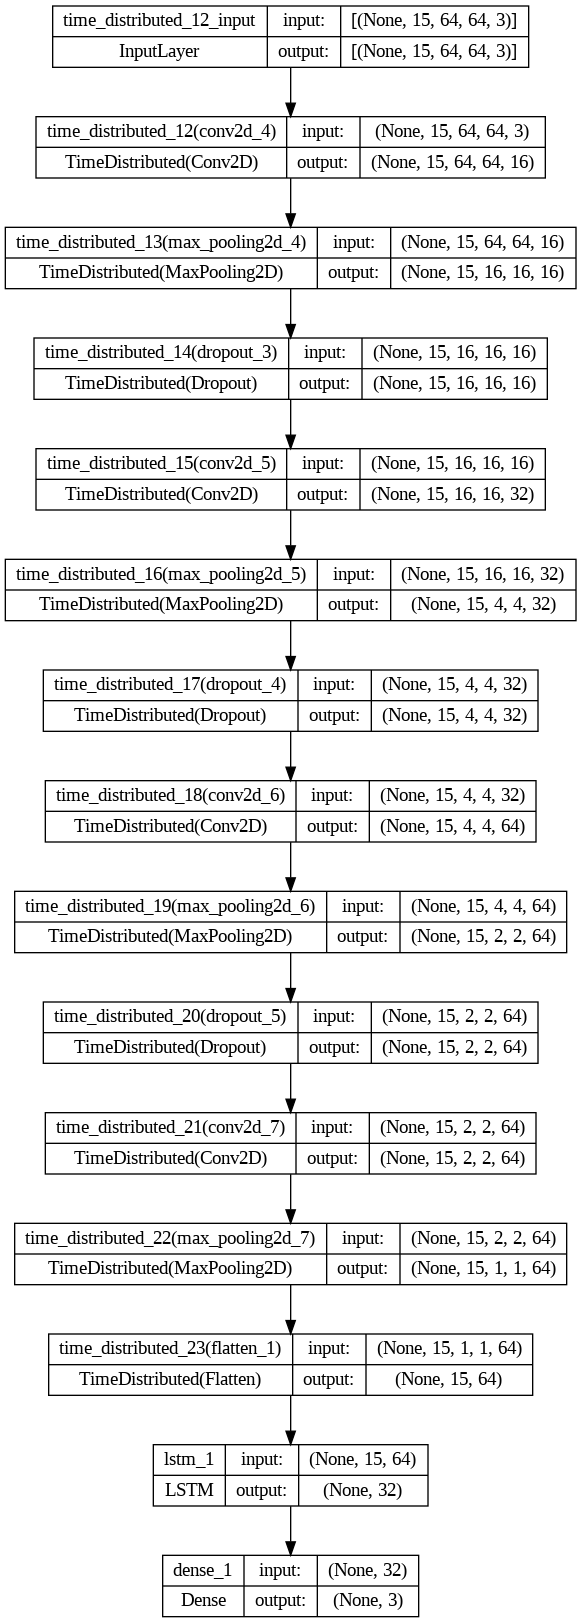

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics to the model.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model using the balanced dataset.
LRCN_model_training_history = LRCN_model.fit(x=balanced_features_train, y=balanced_labels_train, epochs=70, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/70
180/180 [==============================] - 8s 12ms/step - loss: 1.0762 - accuracy: 0.3819 - val_loss: 0.9164 - val_accuracy: 0.5722
Epoch 2/70
180/180 [==============================] - 1s 7ms/step - loss: 0.8059 - accuracy: 0.6292 - val_loss: 0.8861 - val_accuracy: 0.5833
Epoch 3/70
180/180 [==============================] - 1s 7ms/step - loss: 0.6794 - accuracy: 0.6958 - val_loss: 0.6742 - val_accuracy: 0.6778
Epoch 4/70
180/180 [==============================] - 1s 7ms/step - loss: 0.5855 - accuracy: 0.7542 - val_loss: 0.6215 - val_accuracy: 0.7000
Epoch 5/70
180/180 [==============================] - 1s 8ms/step - loss: 0.5469 - accuracy: 0.7694 - val_loss: 0.5396 - val_accuracy: 0.7667
Epoch 6/70
180/180 [==============================] - 1s 8ms/step - loss: 0.5041 - accuracy: 0.7861 - val_loss: 0.5387 - val_accuracy: 0.7444
Epoch 7/70
180/180 [==============================] - 1s 7ms/step - loss: 0.4461 - accuracy: 0.8264 - val_loss: 0.5561 - val_accuracy: 0.7500
Epoch

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = LRCN_model.evaluate(features_test, labels_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 1s 28ms/step - loss: 0.6893 - accuracy: 0.6648
Test Loss: 0.6893066167831421
Test Accuracy: 0.6648044586181641


Using Cross Validation Method

In [ ]:
def augment_sequence(sequence):
    augmentation_choice = random.choice(['flip', 'rotate', 'translate', 'scale'])

    if augmentation_choice == 'flip':
        # Horizontal flip
        return [cv2.flip(frame, 1) for frame in sequence]
    elif augmentation_choice == 'rotate':
        # Random rotation between -10 to 10 degrees
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((sequence[0].shape[1] // 2, sequence[0].shape[0] // 2), angle, 1)
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]
    elif augmentation_choice == 'translate':
        # Random translation
        tx = random.uniform(-10, 10)
        ty = random.uniform(-10, 10)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]
    elif augmentation_choice == 'scale':
        # Random scaling
        scale_factor = random.uniform(0.9, 1.1)
        M = cv2.getRotationMatrix2D((sequence[0].shape[1] // 2, sequence[0].shape[0] // 2), 0, scale_factor)
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]

In [ ]:
def plot_metric(training_history, metric, test_metric, plot_name):
    # Get training metric values
    training_metric_values = training_history.history[metric]
    epochs = range(len(training_metric_values))

    # Plot training metric
    plt.plot(epochs, training_metric_values, 'blue', label=f'Training {metric.capitalize()}')

    # Plot testing metric as a horizontal line
    plt.axhline(y=test_metric, color='red', linestyle='--', label=f'Test {metric.capitalize()}')

    # Add title and legend to the plot
    plt.title(plot_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [ ]:
def balance_dataset(features, labels, class_limit=300):
    decoded_labels = np.argmax(labels, axis=1)
    class_sequences = [[] for _ in range(len(CLASSES_LIST))]

    # Separate features by class
    for i, label in enumerate(decoded_labels):
        class_sequences[label].append(features[i])

    # Balancing logic
    for class_index, sequences in enumerate(class_sequences):
        current_count = len(sequences)
        if current_count > class_limit:
            class_sequences[class_index] = random.sample(sequences, class_limit)
        else:
            augmented_sequences = []
            while len(augmented_sequences) + current_count < class_limit:
                sequence_to_augment = random.choice(sequences)
                augmented_sequences.append(augment_sequence(sequence_to_augment))

            class_sequences[class_index].extend(augmented_sequences)

    # Combine and shuffle the balanced dataset
    balanced_features = np.concatenate(class_sequences)
    balanced_labels = np.concatenate([[to_categorical(i, num_classes=len(CLASSES_LIST)) for _ in range(len(class_sequences[i]))] for i in range(len(CLASSES_LIST))])

    combined = list(zip(balanced_features, balanced_labels))
    random.shuffle(combined)
    balanced_features, balanced_labels = zip(*combined)
    return np.array(balanced_features), np.array(balanced_labels)

In [ ]:
import numpy as np
import random
import itertools
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def create_LRCN_model(conv_filters, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    # First Conv2D layer with MaxPooling (4, 4)
    model.add(TimeDistributed(Conv2D(conv_filters[0], (3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(dropout_rate)))

    # Assume the initial spatial dimensions (height and width)
    spatial_dims = [IMAGE_HEIGHT // 4, IMAGE_WIDTH // 4]  # after the first max-pooling

    # Subsequent Conv2D layers
    for idx, filters in enumerate(conv_filters[1:], start=1):
        model.add(TimeDistributed(Conv2D(filters, (3, 3), padding='same', activation='relu')))

        # Check if the spatial dimensions can be reduced further
        if spatial_dims[0] > 1 and spatial_dims[1] > 1:
            pool_size = (4, 4) if idx < 2 else (2, 2)
            model.add(TimeDistributed(MaxPooling2D(pool_size)))
            # Update the spatial dimensions after max-pooling
            spatial_dims = [dim // pool_size[0] for dim in spatial_dims]

        model.add(TimeDistributed(Dropout(dropout_rate)))

    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(lstm_units))

    # Output layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
# Define the hyperparameter grid
hyperparameter_grid = {
    'conv_filters': [(16, 32, 64, 64), (32, 64, 128, 128)],
    'lstm_units': [32, 64],
    'dropout_rate': [0.25],  # Fixed dropout rate
    'learning_rate': [0.001, 0.0001]
}

def get_all_hyperparameter_combinations(hyperparameter_grid):
    keys, values = zip(*hyperparameter_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.shuffle(combinations)  # Shuffle the combinations
    return combinations

In [ ]:
def count_sequences_per_class(labels, class_list):
    label_counts = Counter(labels)
    class_sequence_counts = {class_name: label_counts.get(i, 0) for i, class_name in enumerate(class_list)}
    return class_sequence_counts

# Count the number of sequences for each class in the training set
train_sequence_counts = count_sequences_per_class(train_labels, CLASSES_LIST)
print("Number of sequences per class in the training set:", train_sequence_counts)

# Count the number of sequences for each class in the test set
test_sequence_counts = count_sequences_per_class(test_labels, CLASSES_LIST)
print("Number of sequences per class in the test set:", test_sequence_counts)

Number of sequences per class in the training set: {'hand_shaking': 258, 'nothing': 2054, 'moving_arms': 114}
Number of sequences per class in the test set: {'hand_shaking': 8, 'nothing': 227, 'moving_arms': 23}


Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_221 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                

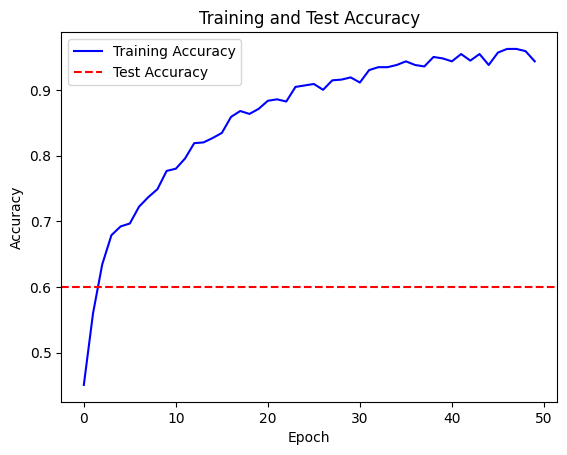

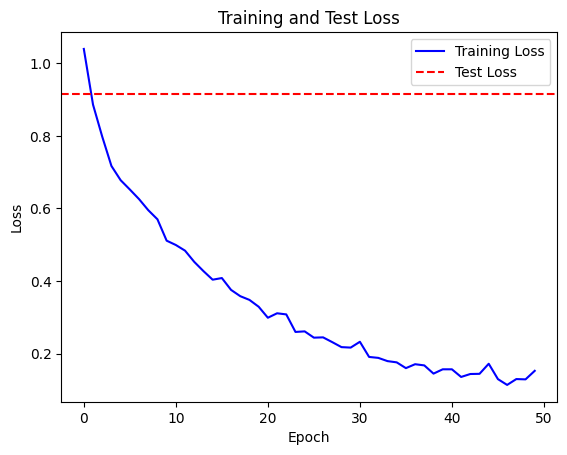

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_234 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_235 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                              

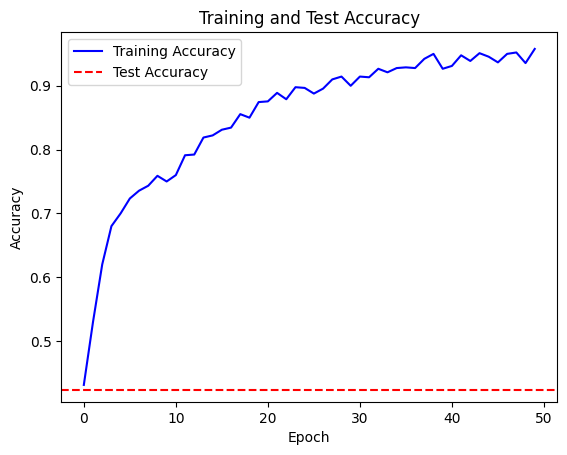

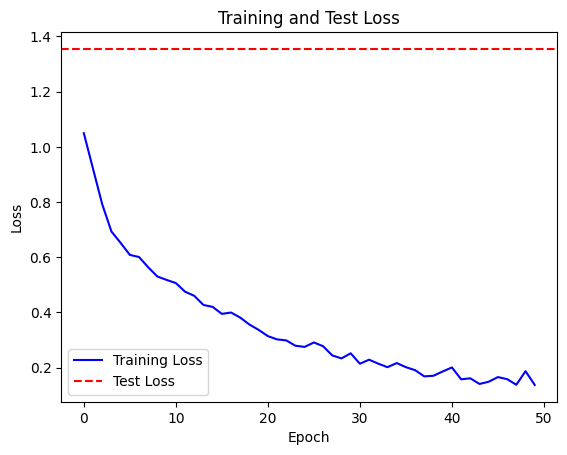

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_247 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 

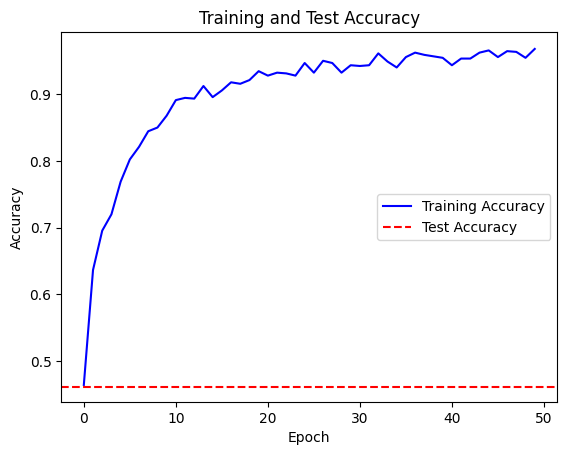

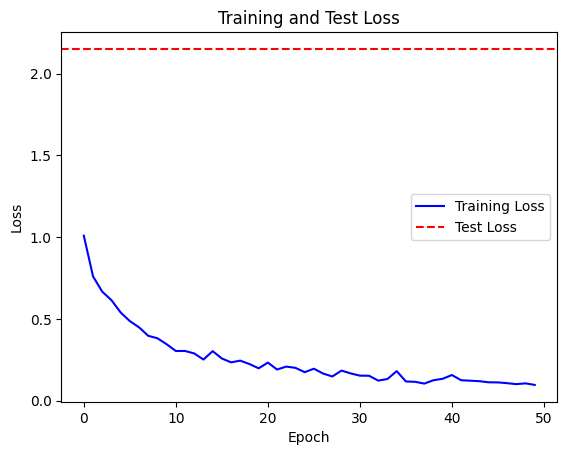

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_260 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_261 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                              

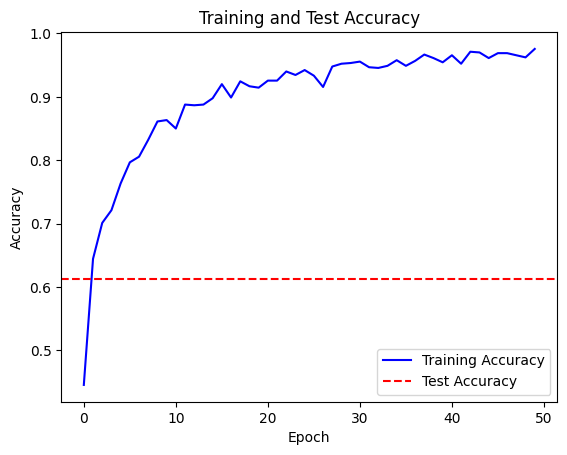

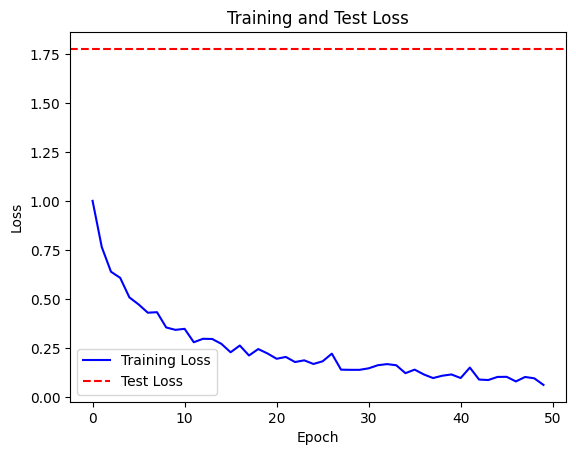

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_273 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 

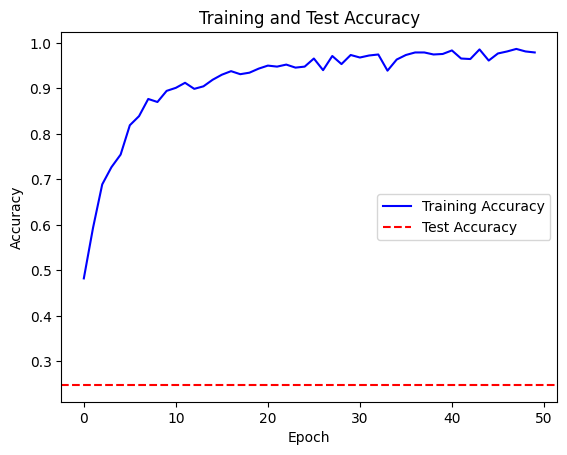

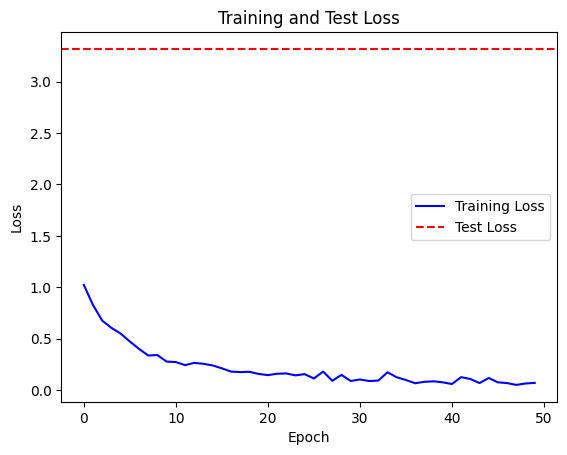

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_286 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_287 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                              

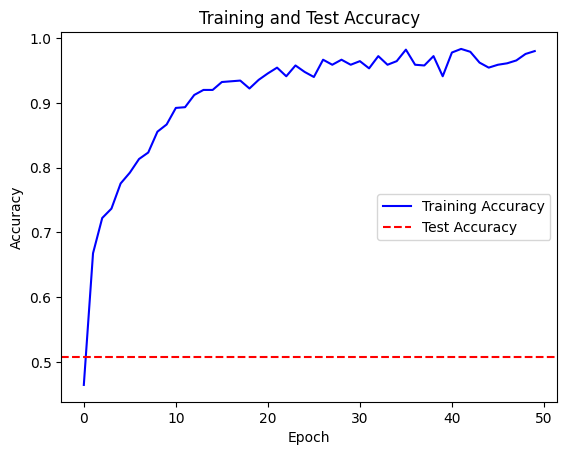

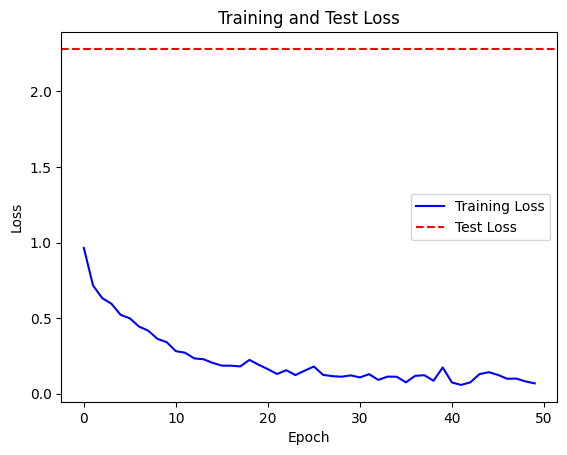

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_299 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 


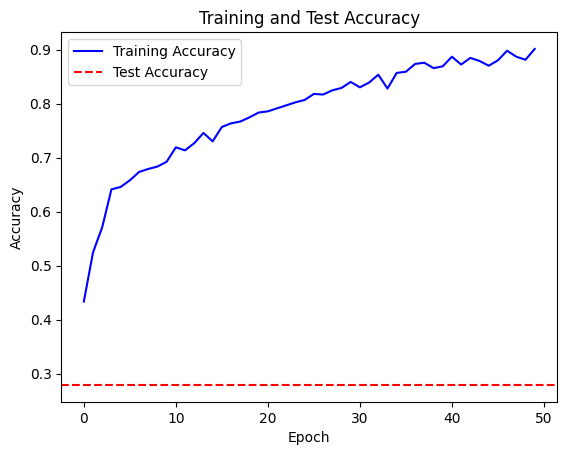

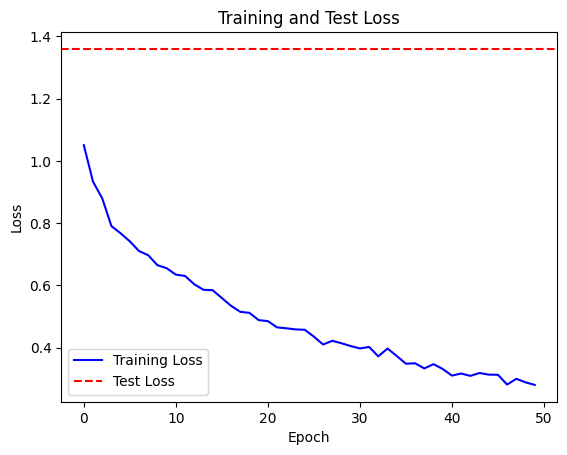

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_312 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_313 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                              

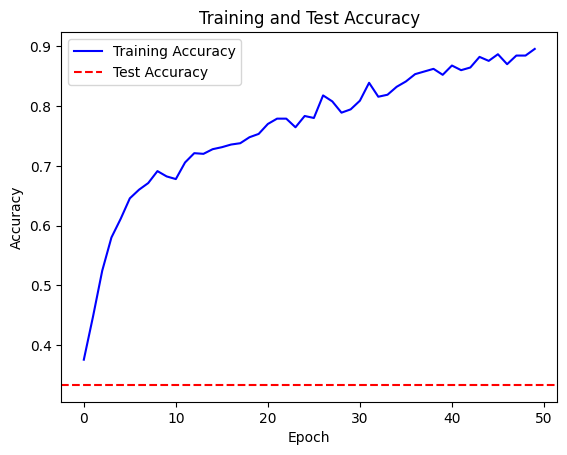

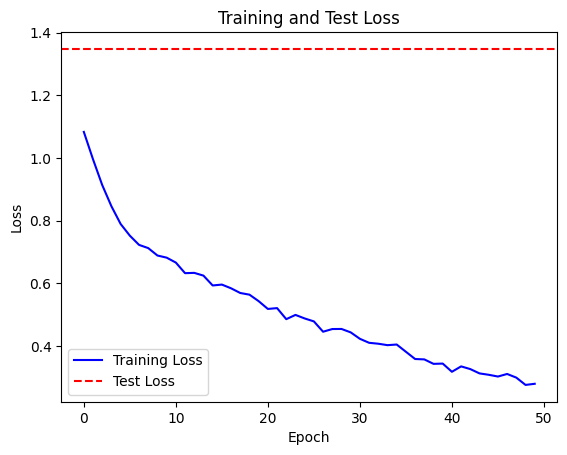

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_325 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 

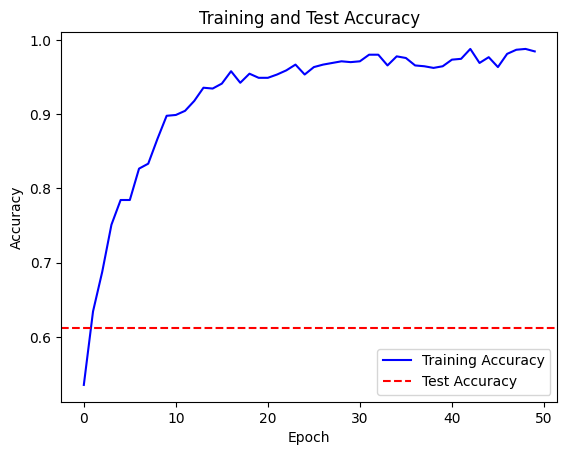

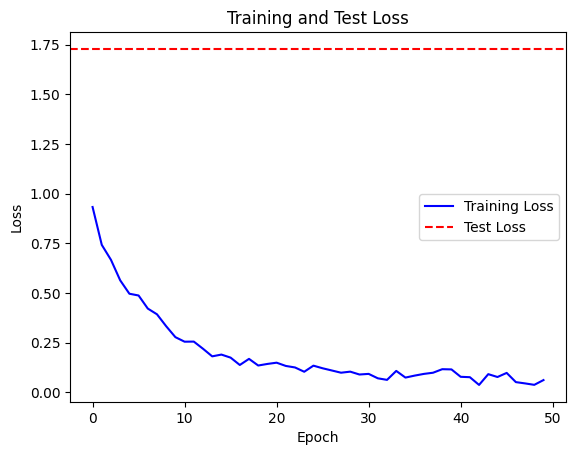

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_338 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_339 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                              

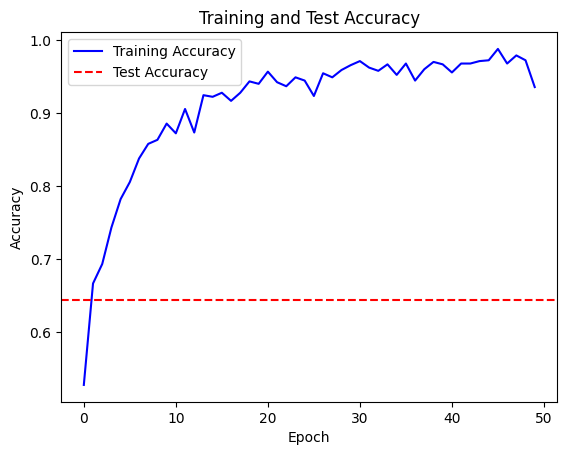

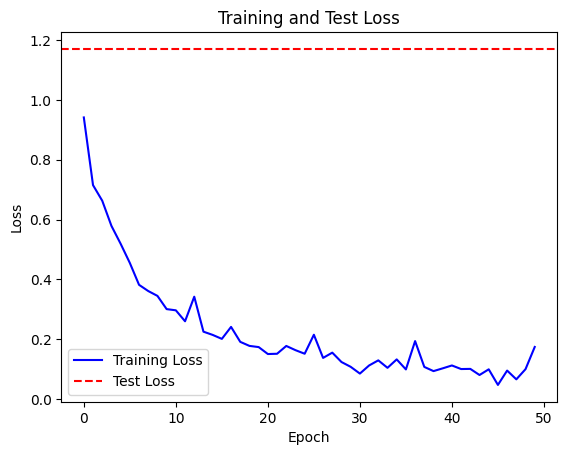

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_351 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 


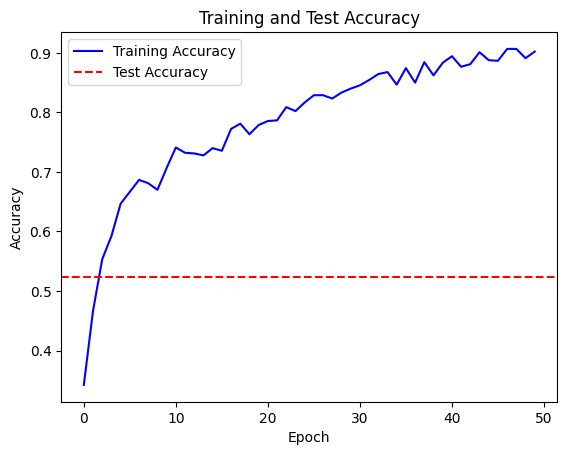

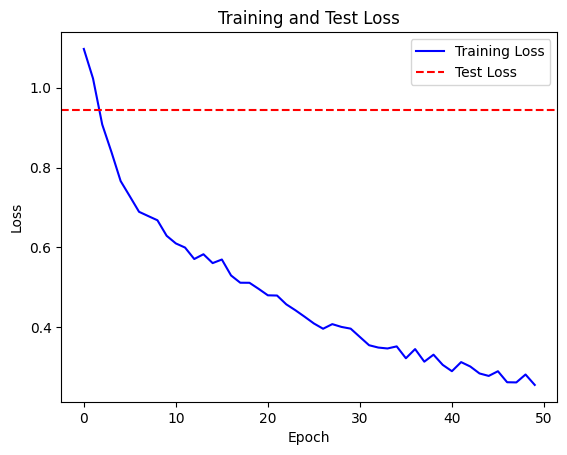

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_364 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_365 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                              

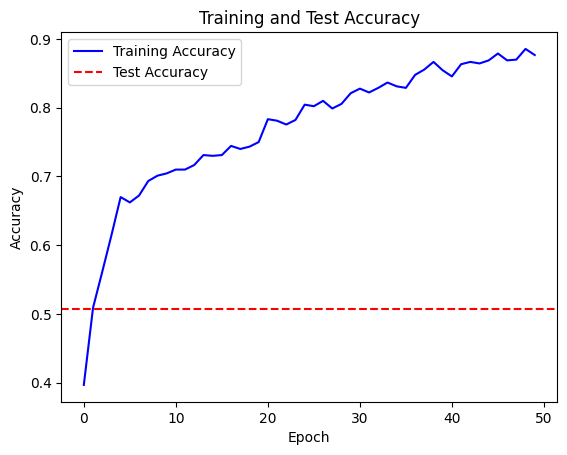

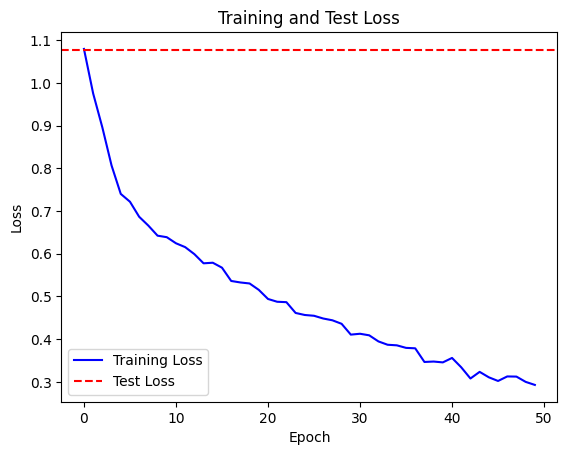

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_377 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                

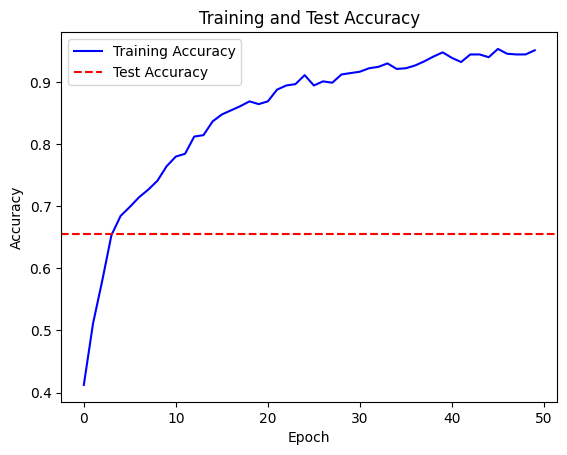

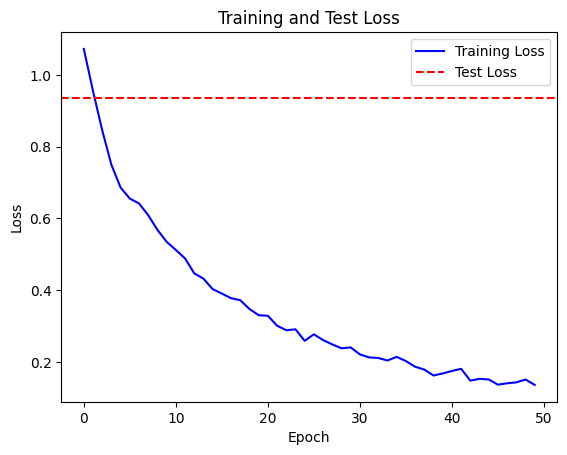

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_390 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_391 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                              

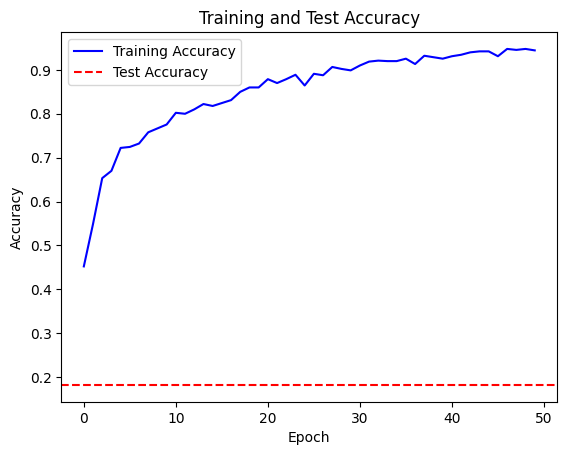

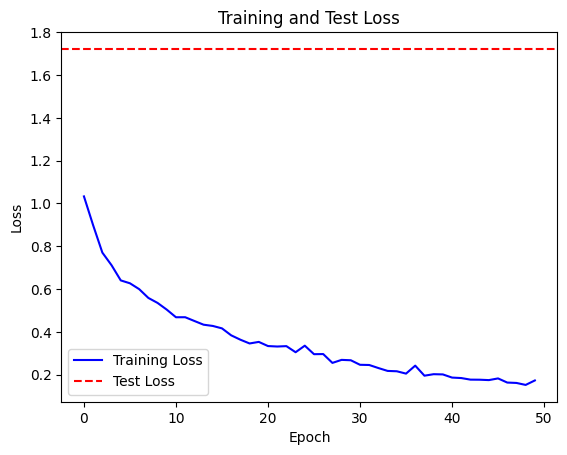

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_403 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 

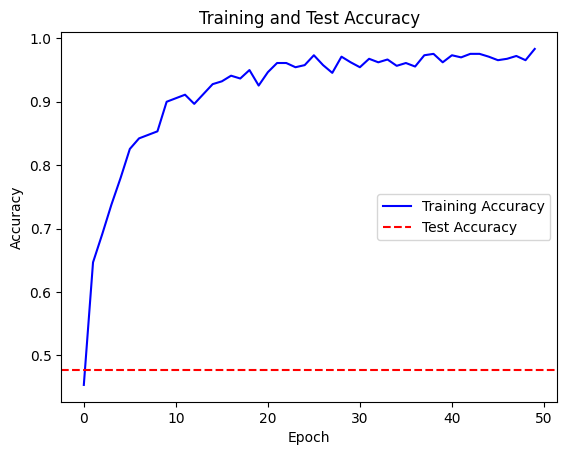

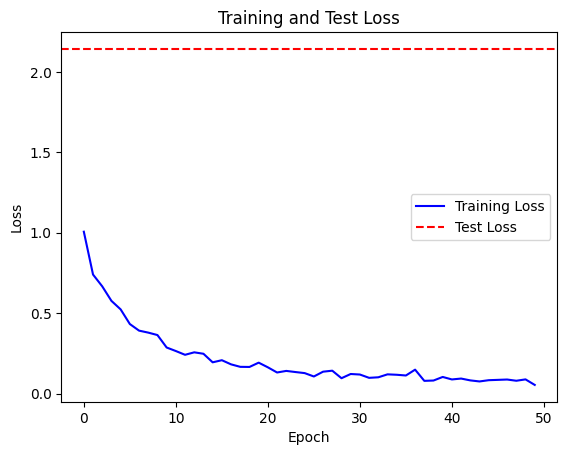

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_416 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_417 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                              

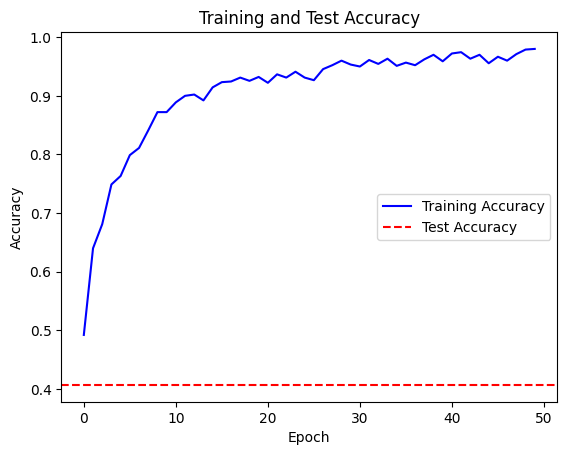

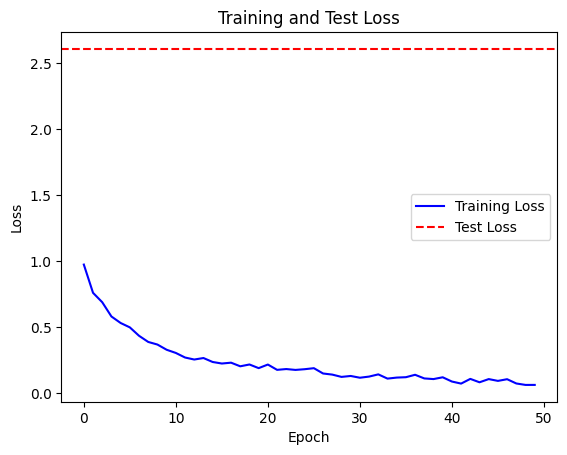

Best Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Best Test Set Accuracy: 0.6279069781303406


In [ ]:
# Split the video paths into training and test sets
video_paths = list(video_timestamps.keys())
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Set up KFold
num_folds = 2  # Adjust the number of folds as needed
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_hyperparams_LRCN = None
best_test_accuracy_LRCN = 0

# Assuming get_all_hyperparameter_combinations and other necessary methods are defined
for hyperparams in get_all_hyperparameter_combinations(hyperparameter_grid):
    print("Current Hyperparameters:", hyperparams)
    test_accuracies = []

    for fold in range(num_folds):
        print(f"Processing fold {fold + 1}")

        # Train and validation data preparation
        train_timestamps = {video: video_timestamps[video] for video in train_videos}
        test_timestamps = {video: video_timestamps[video] for video in test_videos}

        # Generate training and validation (test) datasets
        train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)
        test_features, test_labels, _, _ = create_dataset(test_timestamps)

        # Convert labels to one-hot encoding and balance the training data
        labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
        labels_test_one_hot = to_categorical(test_labels, num_classes=len(CLASSES_LIST))
        balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)

        # Create and compile the LRCN model
        model = create_LRCN_model(hyperparams['conv_filters'], hyperparams['lstm_units'], hyperparams['dropout_rate'], hyperparams['learning_rate'])

        # Fit the model
        history = model.fit(
            x=balanced_features_train,
            y=balanced_labels_train,
            epochs=50,  # Adjust as needed
            batch_size=4,  # Adjust as needed
        )

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_features, labels_test_one_hot)
        test_accuracies.append(test_accuracy)

        # Plot training and test accuracy and loss
        plot_metric(history, 'accuracy', test_accuracy, 'Training and Test Accuracy')
        plot_metric(history, 'loss', test_loss, 'Training and Test Loss')

    # Compute average test set accuracy across folds
    average_test_accuracy = np.mean(test_accuracies)
    if average_test_accuracy > best_test_accuracy_LRCN:
        best_test_accuracy_LRCN = average_test_accuracy
        best_hyperparams_LRCN = hyperparams

# Print the best hyperparameters and their corresponding test set accuracy
print("Best Hyperparameters:", best_hyperparams_LRCN)
print("Best Test Set Accuracy:", best_test_accuracy_LRCN)


In [ ]:
# Split the video paths into training and test sets
video_paths = list(video_timestamps.keys())
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Create dataset for training
train_timestamps = {video: video_timestamps[video] for video in train_videos}
train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)

# Convert labels to one-hot encoding and balance the training data
labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)


# Create dataset for testing
test_timestamps = {video: video_timestamps[video] for video in test_videos}
test_features, test_labels, _, _ = create_dataset(test_timestamps)
labels_test_one_hot = to_categorical(test_labels, num_classes=len(CLASSES_LIST))

# Create and compile the model with the best hyperparameters
model = create_LRCN_model(best_hyperparams_LRCN['conv_filters'],
                          best_hyperparams_LRCN['lstm_units'],
                          best_hyperparams_LRCN['dropout_rate'],
                          best_hyperparams_LRCN['learning_rate'])

# Fit the model on the entire training dataset and validate on the test dataset
history = model.fit(
    balanced_features_train,
    balanced_labels_train,
    epochs=50,
    batch_size=4
)

# Optional: Save the model
model.save('LRCN')

CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_429 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_430 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
           

In [ ]:
# Evaluate the model on the entire test dataset
test_loss, test_accuracy = model.evaluate(test_features, labels_test_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 1s 17ms/step - loss: 2.0176 - accuracy: 0.5349
Test Loss: 2.017598867416382
Test Accuracy: 0.5348837375640869


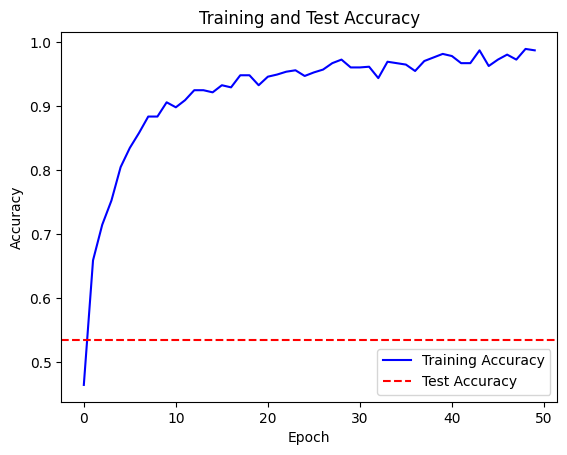

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', test_accuracy, 'Training and Test Accuracy')

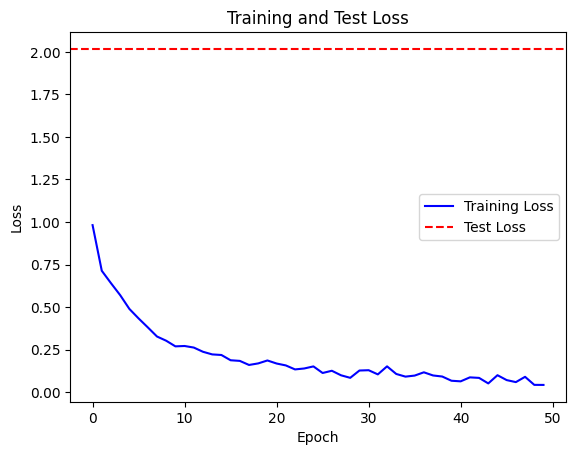

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history, 'loss', test_loss, 'Training and Test Loss')

9/9 [==============================] - 1s 15ms/step


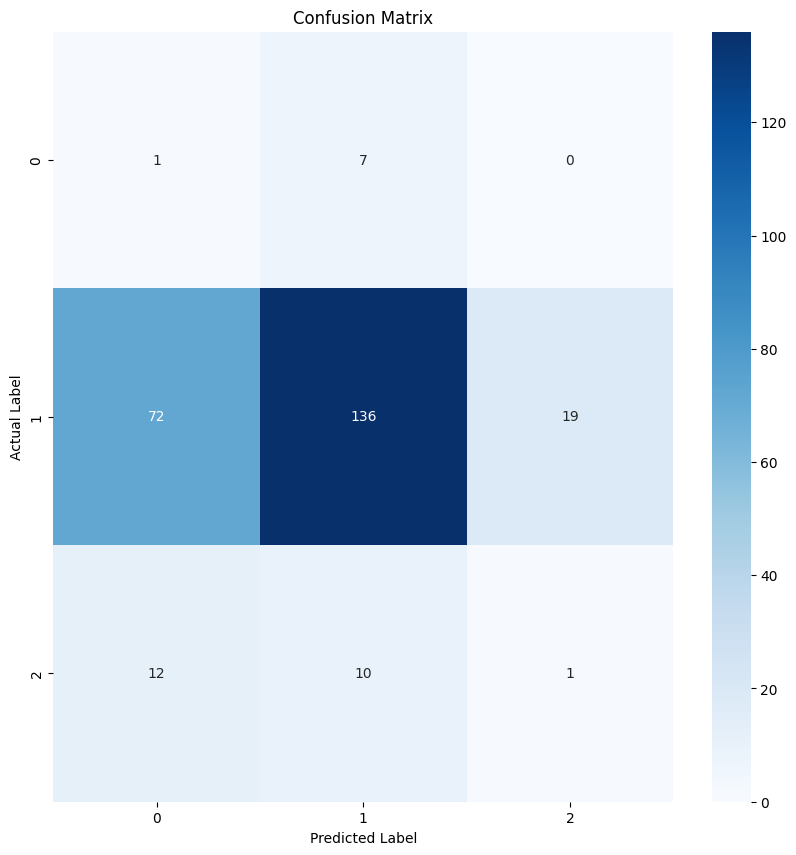

Accuracy: 0.53

Class-wise evaluation metrics:
Class          Precision Recall    F1-Score  Support   
hand_shaking   0.01      0.12      0.02      8         
nothing        0.89      0.60      0.72      227       
moving_arms    0.05      0.04      0.05      23        


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Generate predictions on the test set
predicted_labels = model.predict(test_features)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert probabilities to class labels

true_labels = np.argmax(labels_test_one_hot, axis=1)  # Convert one-hot encoded labels back to class labels
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}\n")
print("Class-wise evaluation metrics:")
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}")
for i, class_label in enumerate(CLASSES_LIST):
    print(f"{class_label:<15}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}{support[i]:<10}")

ResNet LRCN Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import itertools
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def create_LRCN_ResNet_model(lstm_units, dropout_rate, learning_rate, num_unfrozen_layers=None):
    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Decide how many layers to unfreeze
    if num_unfrozen_layers is not None:
        for layer in base_model.layers[:-num_unfrozen_layers]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    model_input = Input(shape=input_shape)
    time_distributed = TimeDistributed(base_model)(model_input)
    time_distributed = TimeDistributed(Flatten())(time_distributed)

    # LSTM layer
    lstm = LSTM(lstm_units)(time_distributed)
    lstm = Dropout(dropout_rate)(lstm)

    # Output layer
    output = Dense(len(CLASSES_LIST), activation='softmax')(lstm)

    model = Model(inputs=model_input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
hyperparameter_grid = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.25],
    'learning_rate': [0.001, 0.0001],
    'num_unfrozen_layers': [None, 5]
}

def get_all_hyperparameter_combinations(hyperparameter_grid):
    keys, values = zip(*hyperparameter_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.shuffle(combinations)  # Shuffle the combinations
    return combinations

In [ ]:
def count_sequences_per_class(labels, class_list):
    label_counts = Counter(labels)
    class_sequence_counts = {class_name: label_counts.get(i, 0) for i, class_name in enumerate(class_list)}
    return class_sequence_counts

train_sequence_counts = count_sequences_per_class(train_labels, CLASSES_LIST)
test_sequence_counts = count_sequences_per_class(test_labels, CLASSES_LIST)

print("Number of sequences per class in the training set:", train_sequence_counts)
print("Number of sequences per class in the test set:", test_sequence_counts)

Number of sequences per class in the training set: {'hand_shaking': 258, 'nothing': 2054, 'moving_arms': 114}
Number of sequences per class in the test set: {'hand_shaking': 8, 'nothing': 227, 'moving_arms': 23}


Current Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001, 'num_unfrozen_layers': None}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_442 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)

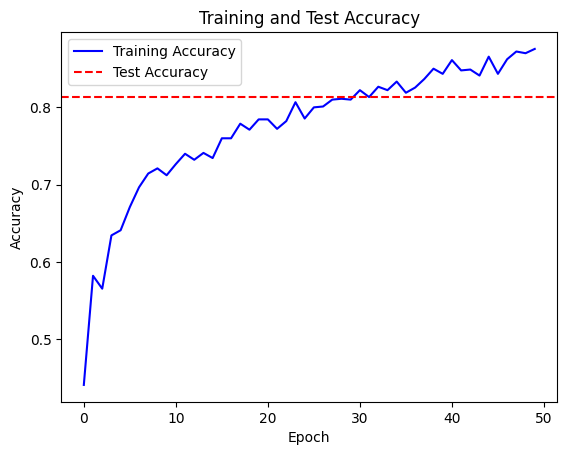

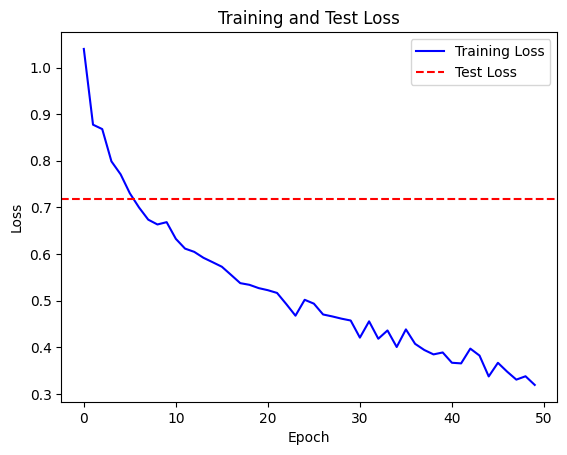

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_444 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 

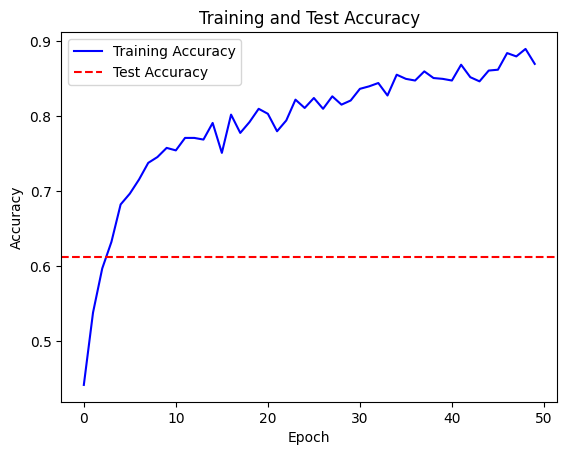

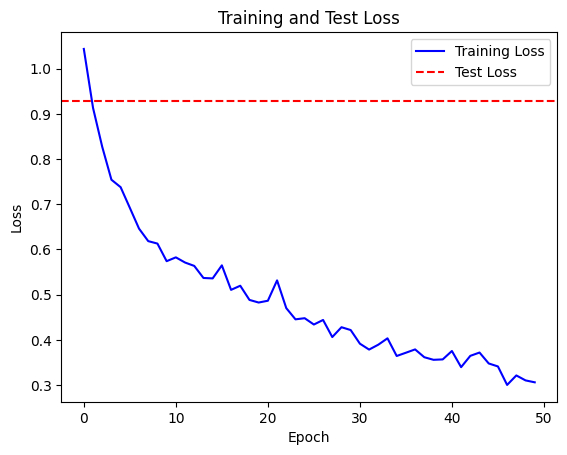

Current Hyperparameters: {'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001, 'num_unfrozen_layers': None}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_446 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distribute

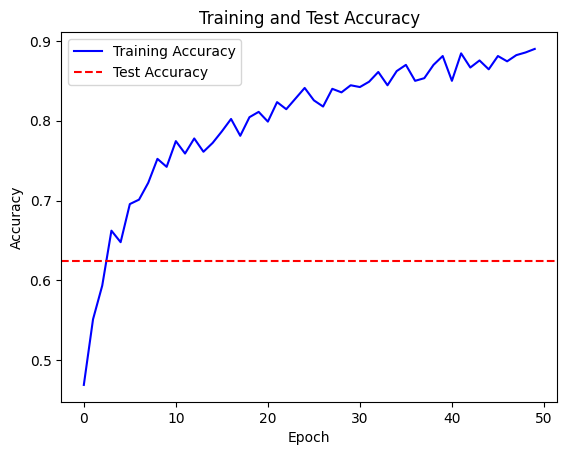

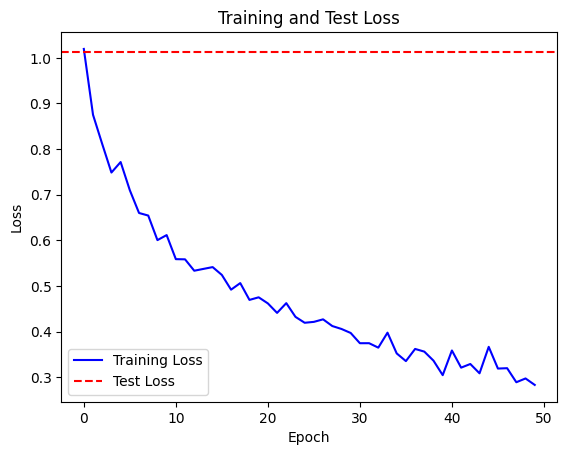

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_448 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 

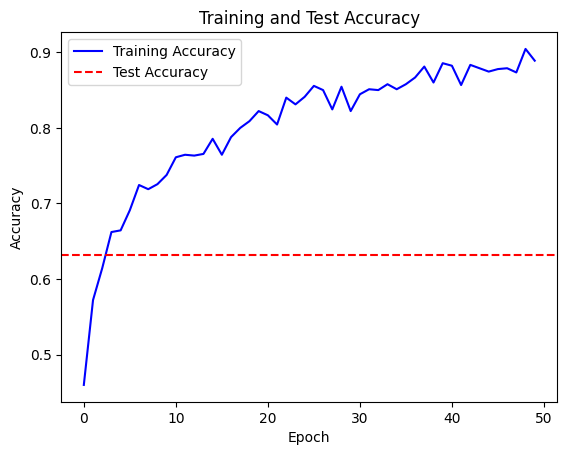

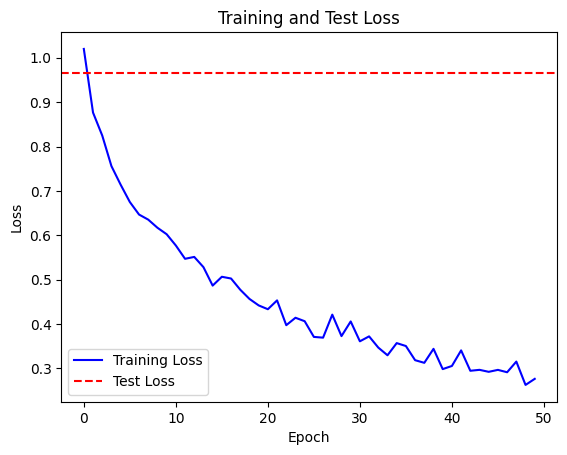

Current Hyperparameters: {'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001, 'num_unfrozen_layers': 5}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_450 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed) 

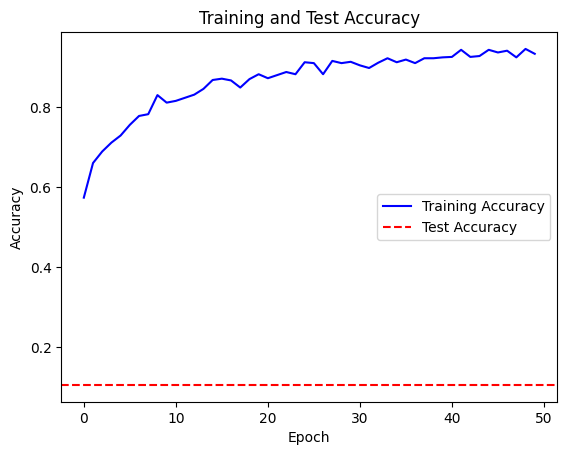

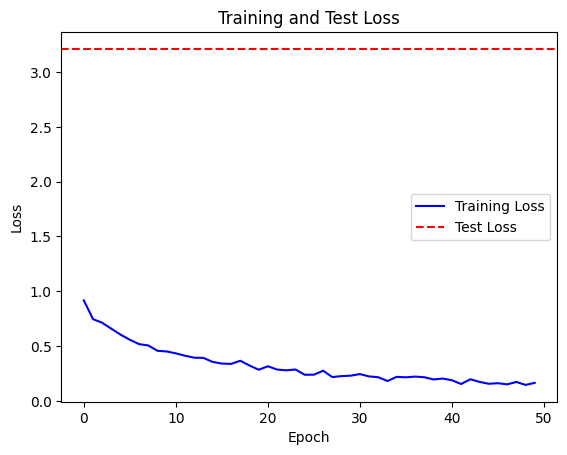

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_452 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 

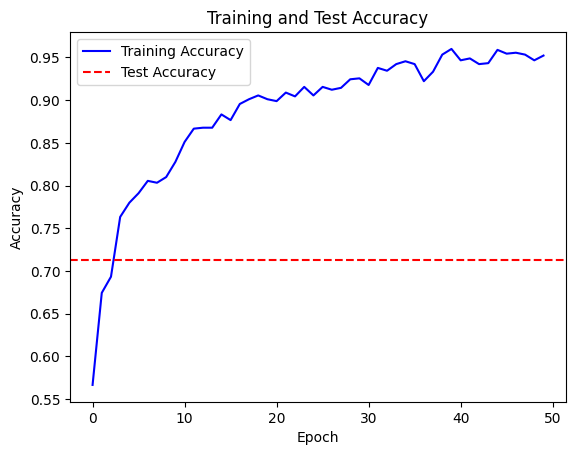

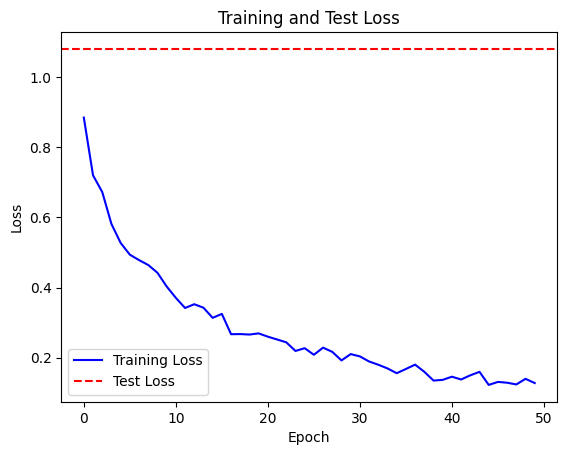

Current Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001, 'num_unfrozen_layers': 5}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_454 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed) 

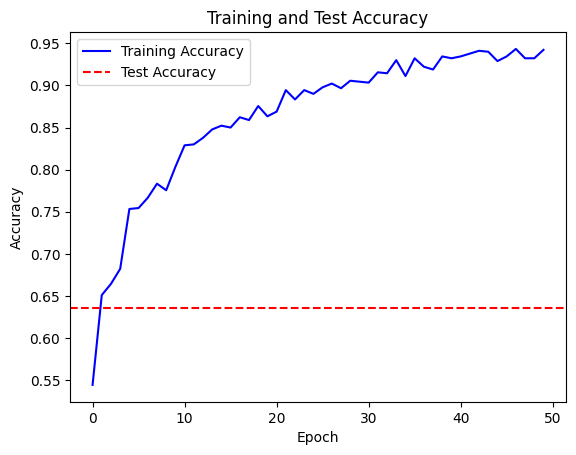

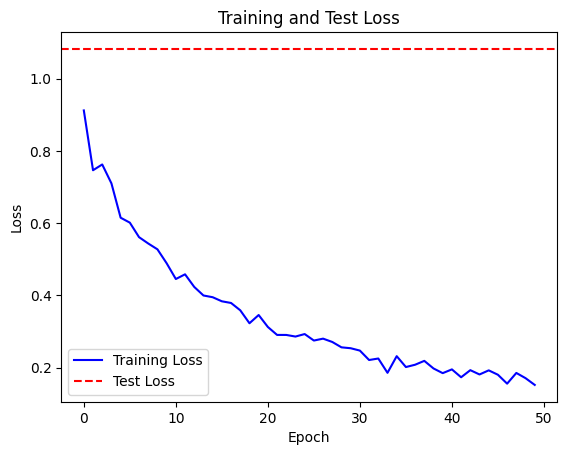

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_456 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 

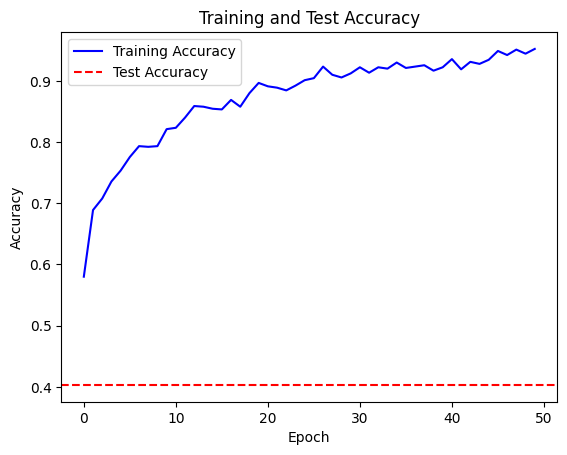

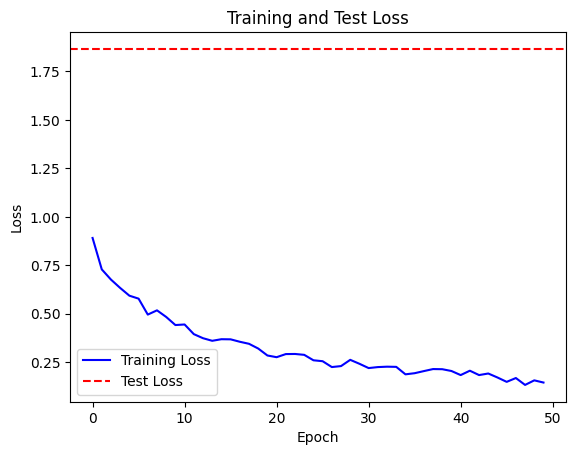

Current Hyperparameters: {'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'num_unfrozen_layers': 5}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_458 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)  

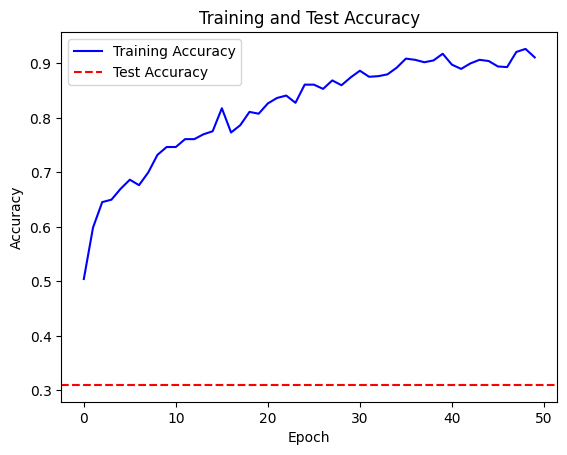

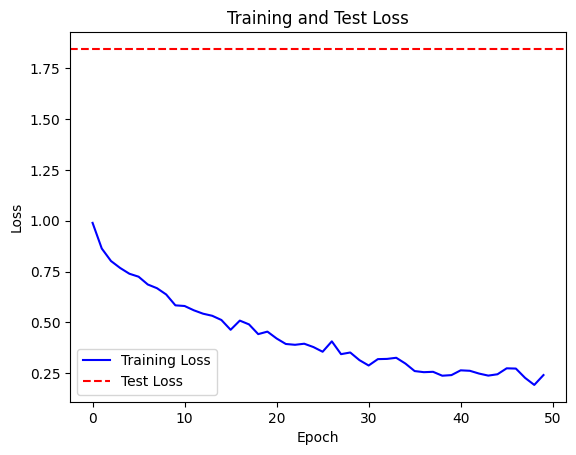

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_460 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 

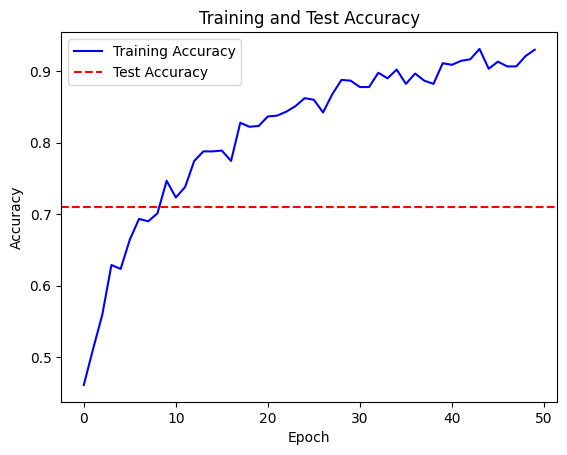

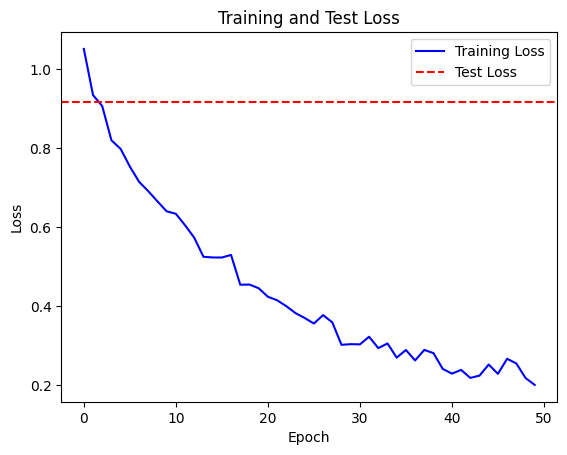

Current Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'num_unfrozen_layers': 5}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_462 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed) 

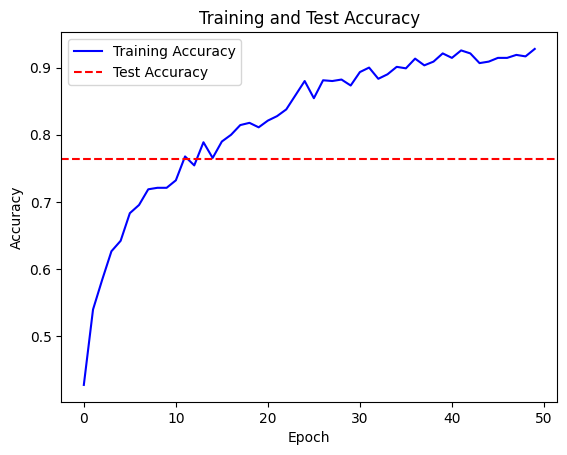

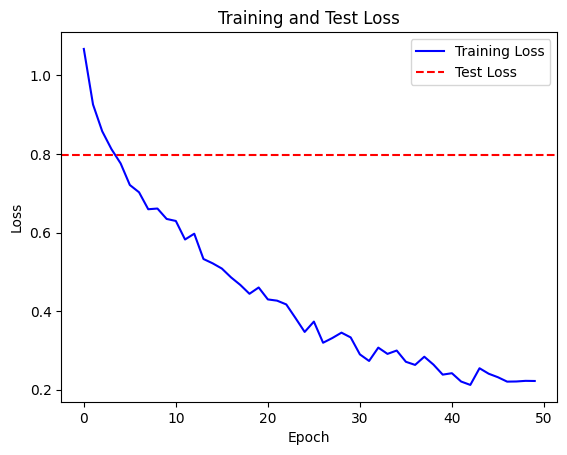

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_464 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                

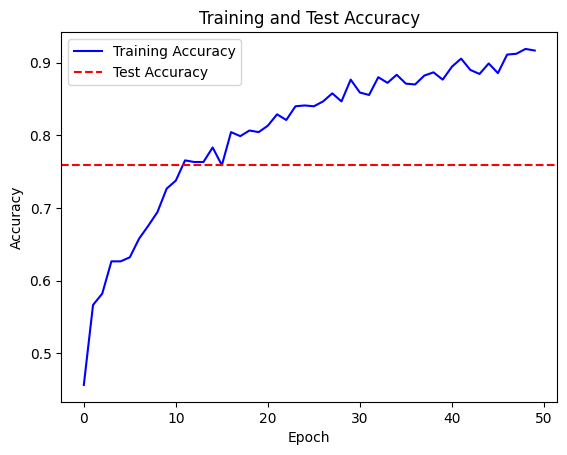

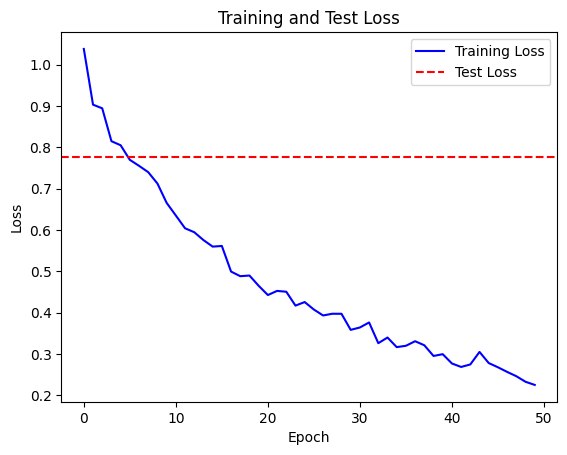

Current Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'num_unfrozen_layers': None}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_466 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distribute

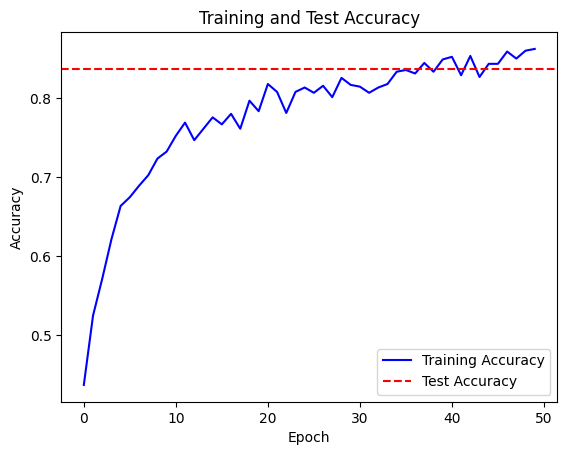

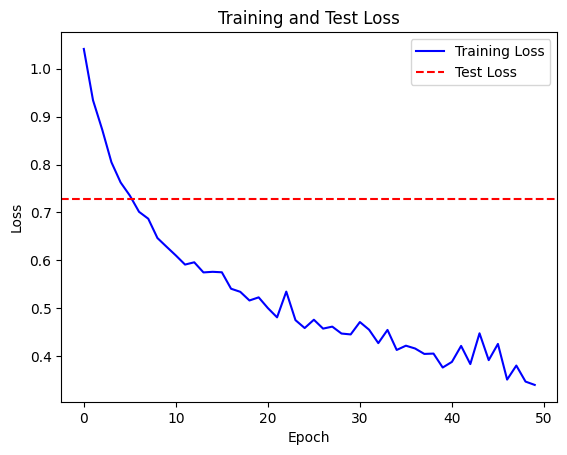

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_468 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                

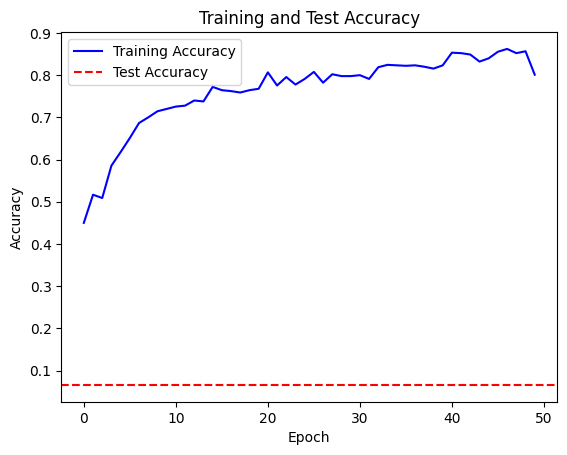

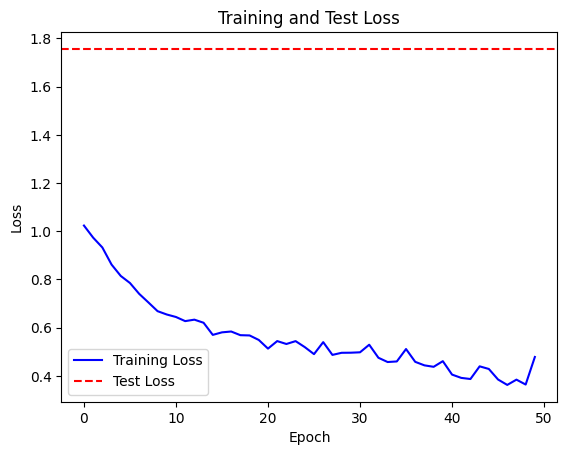

Current Hyperparameters: {'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'num_unfrozen_layers': None}
Processing fold 1
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_470 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distribute

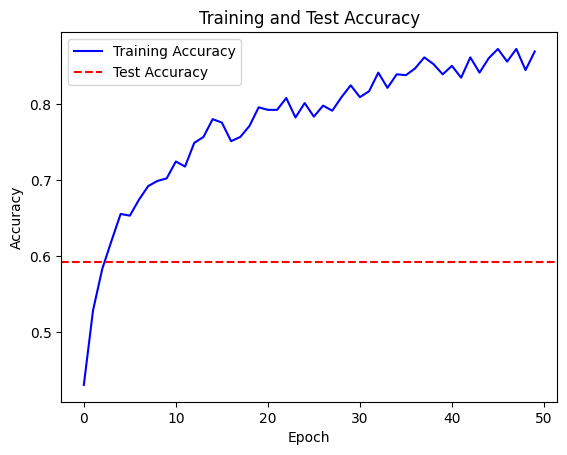

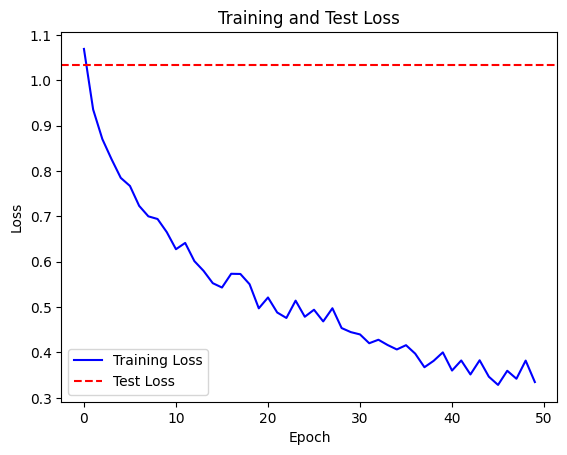

Processing fold 2
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_472 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                

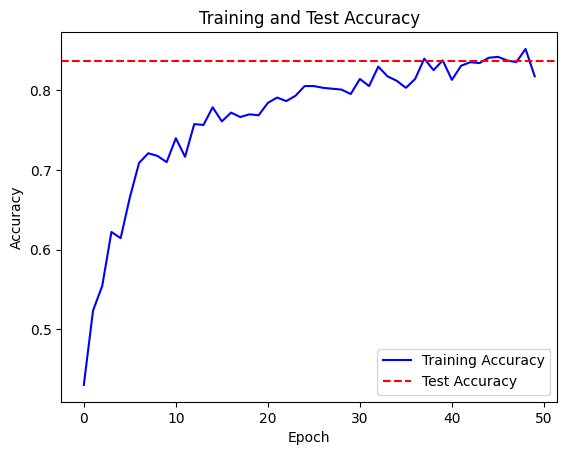

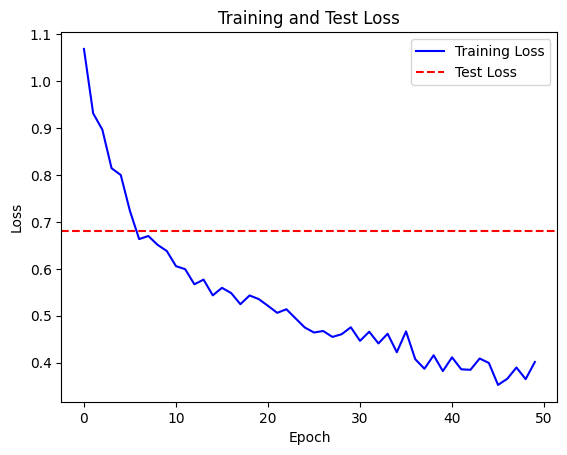

Best Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'num_unfrozen_layers': 5}
Best Test Set Accuracy: 0.7616279125213623


In [ ]:
# Split the video paths into training and test sets
video_paths = list(video_timestamps.keys())
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Set up KFold
num_folds = 2  # Adjust the number of folds as needed
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_hyperparams_resnet = None
best_test_accuracy_resnet = 0  # Renamed for clarity

# Assuming get_all_hyperparameter_combinations and other necessary methods are defined
for hyperparams in get_all_hyperparameter_combinations(hyperparameter_grid):
    print("Current Hyperparameters:", hyperparams)
    test_accuracies = []  # Renamed for clarity

    for fold in range(num_folds):
        print(f"Processing fold {fold + 1}")

        # Train and test data preparation
        train_timestamps = {video: video_timestamps[video] for video in train_videos}
        test_timestamps = {video: video_timestamps[video] for video in test_videos}

        # Generate training and test datasets
        train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)
        test_features, test_labels, _, _ = create_dataset(test_timestamps)

        # Convert labels to one-hot encoding and balance the training data
        labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
        labels_test_one_hot = to_categorical(test_labels, num_classes=len(CLASSES_LIST))
        balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)

        # Create and compile the ResNet model
        model = create_LRCN_ResNet_model(hyperparams['lstm_units'], hyperparams['dropout_rate'], hyperparams['learning_rate'], hyperparams.get('num_unfrozen_layers'))

        # Fit the model
        history = model.fit(
            x=balanced_features_train,
            y=balanced_labels_train,
            epochs=50,  # Adjust as needed
            batch_size=4,  # Adjust as needed
        )

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_features, labels_test_one_hot)
        test_accuracies.append(test_accuracy)

        # Plot training and test accuracy and loss
        plot_metric(history, 'accuracy', test_accuracy, 'Training and Test Accuracy')
        plot_metric(history, 'loss', test_loss, 'Training and Test Loss')

    # Compute average test set accuracy across folds
    average_test_accuracy = np.mean(test_accuracies)
    if average_test_accuracy > best_test_accuracy_resnet:
        best_test_accuracy_resnet = average_test_accuracy
        best_hyperparams_resnet = hyperparams

# Print the best hyperparameters and their corresponding test set accuracy
print("Best Hyperparameters:", best_hyperparams_resnet)
print("Best Test Set Accuracy:", best_test_accuracy_resnet)

In [ ]:
# Split the video paths into training and test sets
video_paths = list(video_timestamps.keys())
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Create dataset for training
train_timestamps = {video: video_timestamps[video] for video in train_videos}
train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)

# Convert labels to one-hot encoding and balance the training data
labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)


# Create dataset for testing
test_timestamps = {video: video_timestamps[video] for video in test_videos}
test_features, test_labels, _, _ = create_dataset(test_timestamps)
labels_test_one_hot = to_categorical(test_labels, num_classes=len(CLASSES_LIST))

# Create and compile the model with the best hyperparameters
model = create_LRCN_ResNet_model(best_hyperparams_resnet['lstm_units'],
                                 best_hyperparams_resnet['dropout_rate'],
                                 best_hyperparams_resnet['learning_rate'],
                                 best_hyperparams_resnet.get('num_unfrozen_layers'))

# Fit the model on the entire training dataset and validate on the test dataset
history = model.fit(
    balanced_features_train,
    balanced_labels_train,
    epochs=50,
    batch_size=4
)

# Optional: Save the model
model.save('ResNet_LRCN')

CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_482 (Time  (None, 15, 2, 2, 2048)    23587712  
 Distributed)                                                    
                                                                 
 time_distribute

In [ ]:
# Evaluate the model on the entire test dataset
test_loss, test_accuracy = model.evaluate(test_features, labels_test_one_hot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 3s 106ms/step - loss: 1.0338 - accuracy: 0.6357
Test Loss: 1.0337557792663574
Test Accuracy: 0.6356589198112488


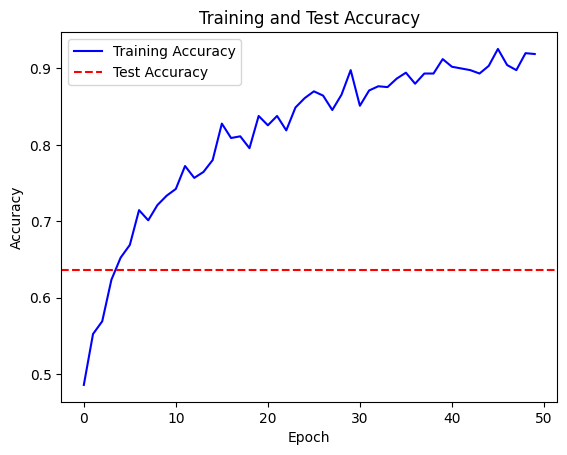

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', test_accuracy, 'Training and Test Accuracy')

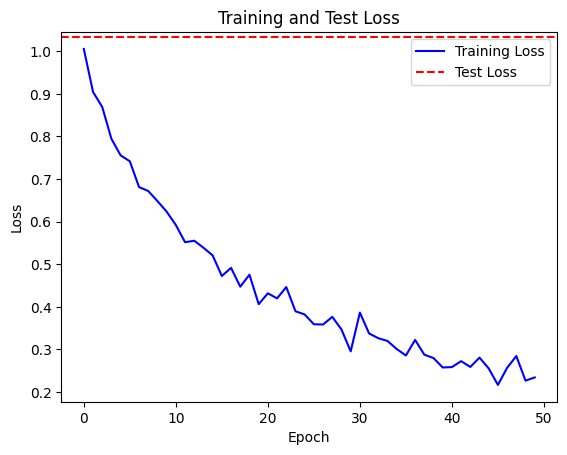

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(history, 'loss', test_loss, 'Training and Test Loss')

9/9 [==============================] - 3s 104ms/step


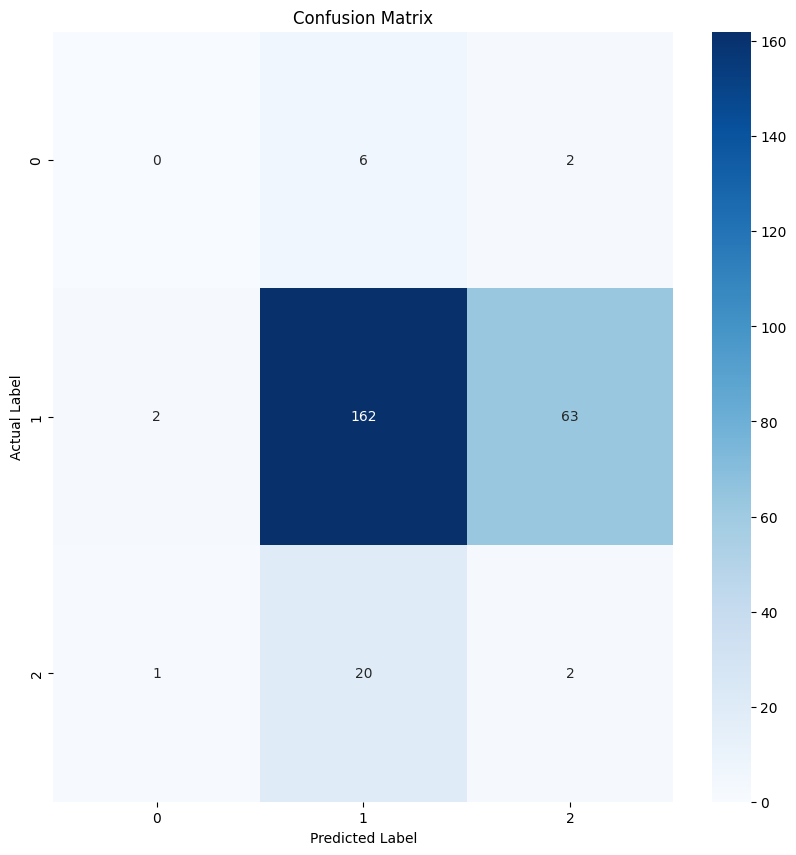

Accuracy: 0.64

Class-wise evaluation metrics:
Class          Precision Recall    F1-Score  Support   
hand_shaking   0.00      0.00      0.00      8         
nothing        0.86      0.71      0.78      227       
moving_arms    0.03      0.09      0.04      23        


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Generate predictions on the test set
predicted_labels = model.predict(test_features)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert probabilities to class labels

true_labels = np.argmax(labels_test_one_hot, axis=1)  # Convert one-hot encoded labels back to class labels
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}\n")
print("Class-wise evaluation metrics:")
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}")
for i, class_label in enumerate(CLASSES_LIST):
    print(f"{class_label:<15}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}{support[i]:<10}")